In [ ]:
!pip install tensorflow

In [ ]:
#To check/confirm for the sampling rate and number of channels of the audio recordings in each dataset

import librosa

file_path = "/content/anger14.wav" # an audio file from one of the primary data collected locally
y, sr = librosa.load(file_path, sr=None, mono=False)

print(f"Sampling Rate: {sr}")
print(f"Number of Channels: {'Mono' if y.ndim == 1 else 'Stereo'}")

Sampling Rate: 44100
Number of Channels: Stereo


THE NEXT X CODE CELLS IS TO DO SOME BASIC HANDLING ON THE DATASETS
I USED GOOGLE COLAB THROUGHT THE WORK, SO I HAD TO UPLOAD THE DATASETS PREPROCESS THEM AND SAVE IT TO MY DRIVE. SO I HAD TO ZIP AND UNZIP THE DATASETS IN THE PROCESS.

YOU MIGHT NOT GO THROUGH THESE PROCESSES IF YOU ARE DOING YOUR WORK LOCALLY.

In [ ]:
# To mount your drive directly.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# To unmount your drive
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [ ]:
!file /content/CREMA-D.zip
!unzip /content/CREMA-D.zip -d unzipped_dataset_CREMA-DData


In [ ]:
#I used these code cells to UNZIP all the datasets

import zipfile
import os

def unzip_file(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        print(f"✔ Extracted to: {extract_to}")

zip_path = "/content/TESS.zip"
extract_to = "unzipped_dataset_TESSData"
unzip_file(zip_path, extract_to)

✔ Extracted to: unzipped_dataset_TESSData


In [ ]:
# This goes through a dataset and check if the audio files are in 16kHz and mono channel, if not it converts it.
import os
import librosa
import soundfile as sf

def convert_to_16k_mono(input_path, output_path):
    try:
        y, _ = librosa.load(input_path, sr=16000, mono=True)
        sf.write(output_path, y, 16000)
        print(f"✔ Converted: {input_path} → {output_path}")
    except Exception as e:
        print(f"✘ Failed to convert {input_path}: {e}")

def batch_convert_recursive(input_folder, output_folder):
    for root, _, files in os.walk(input_folder):
        for file in files:
            if file.lower().endswith('.wav'):
                # Compute relative path to keep subfolder structure
                rel_path = os.path.relpath(root, input_folder)
                output_dir = os.path.join(output_folder, rel_path)
                os.makedirs(output_dir, exist_ok=True)

                input_path = os.path.join(root, file)
                output_path = os.path.join(output_dir, file)

                convert_to_16k_mono(input_path, output_path)

# 🔧 Replace with your actual folder names
input_folder = "/content/unzipped_dataset_TESSData"
output_folder = "converted_audio_TESSData"

batch_convert_recursive(input_folder, output_folder)

In [ ]:
# If you want to download the just converted datasets to your local computer
import shutil
shutil.make_archive("converted_audio_TESSData", 'zip', "/content/converted_audio_TESSData")  # (output_name, format, source_folder)

from google.colab import files
files.download("converted_audio_TESSData")

#from shutil import make_archive
#make_archive("converted_audio_CREMA-DData", 'zip', "/content/converted_audio_CREMA-DData")

In [ ]:
# For uzipping the contents of any zip folder
import zipfile
import os

zip_path = "/content/featuresSautidb.zip"
extract_to = "unzippedSautidb"

os.makedirs(extract_to, exist_ok=True)

try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        print(f"✅ Unzipped to: {extract_to}")
except zipfile.BadZipFile:
    print("❌ Error: File is not a valid zip archive.")

✅ Unzipped to: unzippedSautidb


In [ ]:
# To count the number of audio files in a dataset
import os

def count_wav_files(root_dir):
    print(f"🔍 Searching for .wav files in: {root_dir}")
    wav_count = 0
    for root, _, files in os.walk(root_dir):
        for f in files:
            if f.lower().endswith('.wav'):
                wav_count += 1
                print(" -", os.path.join(root, f))
    if wav_count == 0:
        print("⚠️ No .wav files found in this folder!")
    return wav_count

# Replace the path below with your dataset directory
folder_path = "/content/unzipped_primaryData"
wav_count = count_wav_files(folder_path)
print(f"\n📊 Total number of .wav files: {wav_count}")

Next, i want to do trimming and amplitude normilization on the audio datasets and also extract the MFCC and LPCC features.

In [ ]:
# CONTINUATION OF PREPROCESSING AND FEATURE EXTRACTION

import os
import librosa
import soundfile as sf
import numpy as np
import scipy.signal

# ---------- LPCC Computation ----------
def compute_lpcc(signal, order=12):
    """Compute LPCCs using LPC coefficients via Levinson-Durbin recursion"""
    # Autocorrelation method to get LPC coefficients
    autocorr = np.correlate(signal, signal, mode='full')
    autocorr = autocorr[len(autocorr)//2:]  # keep only non-negative lags

    if np.all(autocorr == 0):
        return np.zeros(order + 1)

    # Levinson-Durbin recursion
    a = np.zeros(order + 1)
    e = autocorr[0]
    a[0] = 1.0

    for i in range(1, order + 1):
        acc = autocorr[i]
        for j in range(1, i):
            acc += a[j] * autocorr[i - j]
        k = -acc / e
        a_old = a.copy()
        a[1:i] += k * a_old[i - 1:0:-1]
        a[i] = k
        e *= 1 - k**2

    # Convert LPC to LPCC
    lpcc = np.zeros(order + 1)
    lpcc[0] = np.log(autocorr[0])
    for n in range(1, order + 1):
        s = sum([(n - k) * a[k] * lpcc[n - k] for k in range(1, n)])
        lpcc[n] = a[n] + s / n

    return lpcc

# ---------- Audio Processing Function ----------
def preprocess_and_extract(input_path, output_folder, n_mfcc=13, lpcc_order=12):
    try:
        y, sr = librosa.load(input_path, sr=16000, mono=True)

        # Trim silence from the beginning and end
        y_trimmed, _ = librosa.effects.trim(y, top_db=20)

        # Normalize amplitude to [-1, 1]
        y_trimmed = y_trimmed / np.max(np.abs(y_trimmed))

        # Extract MFCCs
        mfcc = librosa.feature.mfcc(y=y_trimmed, sr=sr, n_mfcc=n_mfcc)
        mfcc = mfcc.T  # shape: (frames, n_mfcc)

        # Extract LPCC (one vector per frame using a sliding window)
        frame_length = int(0.025 * sr)   # 25 ms
        hop_length = int(0.010 * sr)     # 10 ms

        lpcc_list = []
        for i in range(0, len(y_trimmed) - frame_length + 1, hop_length):
            frame = y_trimmed[i:i+frame_length]
            lpcc = compute_lpcc(frame, order=lpcc_order)
            lpcc_list.append(lpcc)
        lpcc = np.array(lpcc_list)  # shape: (frames, lpcc_order+1)

        # Combine features: (optional step)
        combined = np.concatenate((mfcc[:min(len(mfcc), len(lpcc))],
                                   lpcc[:min(len(mfcc), len(lpcc))]), axis=1)

        # Save features, if you are also using Colab, you can save it directly to your drive
        os.makedirs(os.path.dirname(output_folder), exist_ok=True)
        np.save(output_folder, combined)
        print(f"✔ Features saved: {output_folder}.npy")

    except Exception as e:
        print(f"✘ Failed to process {input_path}: {e}")

# ---------- Batch Processing ----------
def process_dataset(input_root, output_root):
    for root, _, files in os.walk(input_root):
        for file in files:
            if file.lower().endswith('.wav'):
                input_path = os.path.join(root, file)
                relative_path = os.path.relpath(input_path, input_root)
                relative_name = os.path.splitext(relative_path)[0]
                output_path = os.path.join(output_root, relative_name)

                preprocess_and_extract(input_path, output_path)

# ---------- Run for Your Dataset ----------
input_root = "/content/unzipped_TESSData"     # Already converted to 16kHz mono
output_root = "features_TESSData"           # Where .npy files will be saved. Here you can create a path to be saved directly to your drive

process_dataset(input_root, output_root)

In [ ]:
import shutil

shutil.make_archive("renamedSautidb", 'zip', "/content/unzippedSautidb")
print("✅ Zipped the folder!")

✅ Zipped the folder!


In [ ]:
import zipfile
import os

# Define the ZIP path and where to extract
zip_path = "/content/features_TESSData.zip"
extract_to = "unzipped_extracted_features_TESS"

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# List extracted files to verify
for root, _, files in os.walk(extract_to):
    for f in files:
        print("📄", os.path.join(root, f))

PLOTS OF MFCC FEATURES

FOR BOTH LFCC AND MFCC

In [ ]:
import numpy as np

# Load the .npy file
data = np.load("/content/unzipped_extracted_features_TESS/TESS Toronto emotional speech set data/OAF_Fear/OAF_back_fear.npy")

# Split MFCC and LFCC (first 13 columns are MFCC, next 13 are LFCC)
mfcc = data[:, :13]
lfcc = data[:, 13:]

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.heatmap(mfcc.T, cmap="coolwarm")
plt.title("MFCCs Over Time")
plt.xlabel("Frame")
plt.ylabel("MFCC Coefficients")

plt.subplot(1, 2, 2)
sns.heatmap(lfcc.T, cmap="viridis")
plt.title("LFCCs Over Time")
plt.xlabel("Frame")
plt.ylabel("LFCC Coefficients")

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))

plt.plot(np.mean(mfcc, axis=1), label="MFCC Mean")
plt.plot(np.mean(lfcc, axis=1), label="LFCC Mean")
plt.title("Average Feature Value Over Time")
plt.xlabel("Time Frame")
plt.ylabel("Mean Value")
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(np.std(mfcc, axis=1), label="MFCC Std")
plt.plot(np.std(lfcc, axis=1), label="LFCC Std")
plt.title("Feature Variation (Std Dev) Over Time")
plt.xlabel("Time Frame")
plt.ylabel("Standard Deviation")
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))

plt.hist(mfcc[:, 0], bins=20, alpha=0.6, label="MFCC[0]")
plt.hist(lfcc[:, 0], bins=20, alpha=0.6, label="LFCC[0]")
plt.title("Distribution of First Coefficient")
plt.xlabel("Feature Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
mfcc_2d = pca.fit_transform(mfcc)
lfcc_2d = pca.fit_transform(lfcc)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.scatter(mfcc_2d[:, 0], mfcc_2d[:, 1], c=range(len(mfcc)), cmap="viridis")
plt.title("MFCC PCA Projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Time Frame")

plt.subplot(1, 2, 2)
plt.scatter(lfcc_2d[:, 0], lfcc_2d[:, 1], c=range(len(lfcc)), cmap="plasma")
plt.title("LFCC PCA Projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Time Frame")

plt.tight_layout()
plt.show()

Stats summary for dataset and spectogram for an audio file

/content/unzipped_TESS/TESS Toronto emotional speech **set** data/OAF_neutral/OAF_date_neutral.wav


In [ ]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np

file_path = "/content/anger14.wav"
y, sr = librosa.load(file_path)

#compute the Short-Time Fourier Transform (STFT)
D = np.abs(librosa.stft(y))
#convert amplitude to db
DB = librosa.amplitude_to_db(D, ref=np.max)
#plot the spectogram
plt.figure(figsize=(10, 6))
librosa.display.specshow(DB, sr=sr, x_axis='time', y_axis='linear') #use 'log' for log scale
plt.colorbar(format='%+2.0f dB')
plt.title('Normal Spectogram(Linear Frequency Scale)')
plt.tight_layout()
plt.show()

In [ ]:
# Patch for librosa's use of deprecated np.complex
import numpy as np
np.complex = complex

# Re-import the required libraries after patching
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display
import seaborn as sns

# Configuration
dataset_path = "/content/unzipped_extracted_features_TESS"
audio_example_path = "/content/anger14.wav"

# 1. Compute Summary Statistics
def compute_dataset_summary_stats(root_path):
    summary = {
        "file_count": 0,
        "mean_per_feature": [],
        "std_per_feature": [],
    }

    all_features = []

    for root, _, files in os.walk(root_path):
        for f in files:
            if f.endswith(".npy"):
                full_path = os.path.join(root, f)
                try:
                    data = np.load(full_path)
                    if data.shape[1] == 26:
                        all_features.append(data)
                        summary["file_count"] += 1
                except Exception as e:
                    print(f"Error reading {f}: {e}")

    if all_features:
        stacked = np.vstack(all_features)
        summary["mean_per_feature"] = np.mean(stacked, axis=0)
        summary["std_per_feature"] = np.std(stacked, axis=0)

    return summary

dataset_summary = compute_dataset_summary_stats(dataset_path)

# 2. Generate Spectrogram
def generate_spectrogram(audio_path, title="Spectrogram"):
    y, sr = librosa.load(audio_path, sr=16000)
    plt.figure(figsize=(10, 4))
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

generate_spectrogram(audio_example_path, title="Mel Spectrogram: anger14.wav")

dataset_summary

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example path to one file (update this if you want a different one)
file_path = "/content/unzipped_extracted_features_TESS/TESS Toronto emotional speech set data/YAF_happy/YAF_choice_happy.npy"

# Load the features
features = np.load(file_path)

# Inspect
print("Shape:", features.shape)
print("Sample values:\n", features)

plt.figure(figsize=(10, 6))
sns.heatmap(features.T, cmap='viridis', xticklabels=False)
plt.title("MFCC Feature Heatmap (Transposed)")
plt.xlabel("Time Frames")
plt.ylabel("MFCC Coefficients")
plt.show()

mean_mfcc = np.mean(features, axis=1)
std_mfcc = np.std(features, axis=1)

plt.figure(figsize=(10, 4))
plt.plot(mean_mfcc, label='Mean per Frame')
plt.plot(std_mfcc, label='Std per Frame')
plt.title("Mean and Std of MFCCs Over Time")
plt.xlabel("Time Frame")
plt.ylabel("Value")
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(features[:, 0], bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of 1st MFCC Coefficient")
plt.xlabel("Coefficient Value")
plt.ylabel("Frequency")
plt.show()

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced = pca.fit_transform(features)

plt.figure(figsize=(6, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], c=np.arange(len(reduced)), cmap='cool', s=30)
plt.title("PCA Projection of MFCC Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Frame Index')
plt.grid(True)
plt.show()

Comparison of Two Emotions Using the features

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set paths to two emotion folders
happy_path = "/content/unzipped_extracted_features_TESS/TESS Toronto emotional speech set data/OAF_happy"
angry_path = "/content/unzipped_extracted_features_TESS/TESS Toronto emotional speech set data/OAF_angry"

def load_npy_files(folder_path, max_files=10):
    """Load and stack multiple .npy files from a folder"""
    features = []
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith('.npy'):
            path = os.path.join(folder_path, filename)
            data = np.load(path)
            features.append(data)
            if len(features) >= max_files:
                break
    return features

# Load features
happy_features = load_npy_files(happy_path)
angry_features = load_npy_files(angry_path)

# Ensure same shape (crop to minimum length if needed)
min_len = min([f.shape[0] for f in happy_features + angry_features])
happy_stack = np.array([f[:min_len] for f in happy_features])
angry_stack = np.array([f[:min_len] for f in angry_features])

# Compute mean across samples
happy_mean = np.mean(happy_stack, axis=0)   # shape: (frames, features)
angry_mean = np.mean(angry_stack, axis=0)

# ========== 🔹 PLOT 1: Mean Feature Evolution Over Time 🔹 ==========
plt.figure(figsize=(12, 6))
plt.plot(happy_mean[:, 0], label='Happy - Feature 1', color='blue')
plt.plot(angry_mean[:, 0], label='angry - Feature 1', color='red')
plt.title("Feature 1 (e.g., MFCC 1) Over Time")
plt.xlabel("Frame Index")
plt.ylabel("Feature Value")
plt.legend()
plt.grid(True)
plt.show()

# ========== 🔹 PLOT 2: Heatmaps of Average Feature Maps 🔹 ==========
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.heatmap(happy_mean.T, cmap='coolwarm', xticklabels=False, yticklabels=1)
plt.title("Heatmap: Average Features (Happy)")

plt.subplot(1, 2, 2)
sns.heatmap(angry_mean.T, cmap='coolwarm', xticklabels=False, yticklabels=1)
plt.title("Heatmap: Average Features (Angry)")
plt.show()

# ========== 🔹 PLOT 3: Histogram of One Feature Across Samples 🔹 ==========
happy_f1 = [sample[0, 0] for sample in happy_stack]  # feature 1, frame 0
angry_f1 = [sample[0, 0] for sample in angry_stack]

plt.figure(figsize=(10, 5))
plt.hist(happy_f1, bins=10, alpha=0.6, label="Happy", color='blue')
plt.hist(angry_f1, bins=10, alpha=0.6, label="angry", color='red')
plt.title("Histogram of Feature 1 (Frame 0)")
plt.xlabel("Feature Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

I merged the emotions to just five distinct ones.

In [ ]:
import os
import numpy as np
from tqdm import tqdm
import re
from collections import Counter

# ✅ Emotion label mapping including merging (happy, angry, neutral, etc.)
def extract_emotion_label(filename):
    basename = os.path.basename(filename)
    filename = filename.lower()

    # ✅ 1. Keyword-based mapping (primary, custom datasets)
    full_map = {
        'happy': 'happy',
        'pleasant_surprise': 'happy',
        'surprise': 'happy',
        'suprise': 'happy',
        'sad': 'sad',
        'neutral': 'neutral',
        'calm': 'neutral',
        'angry': 'angry',
        'anger': 'angry',
        'disgust': 'angry',
        'fear': 'fear'
    }
    for key in full_map:
        if key in filename:
            return full_map[key]

    # ✅ 2. EMO-DB
    #if "EMO-DB" in filename or re.match(r"\d{2}[a-z]{3}[A-Z][a-z]\.npy$", basename):

    # ✅ Detect EMO-DB using regex, extract emotion code like 'Fa', 'Wc', etc.
    match = re.match(r"\d{2}[a-z]\d{2}([A-Z][a-z])\.npy$", basename)
    if "EMO-DB" in filename or match:
        if match:
            emo_letter = match.group(1)  # extract the emotion code (e.g., 'Wc')
            print(f"[DEBUG] EMO-DB detected → {basename} → emotion code: {emo_letter}")

            emodb_map = {
                'Wa': 'angry',  'Wb': 'angry',  'Wc': 'angry',  'Wd': 'angry',  'We': 'angry',
                'La': 'neutral','Lb': 'neutral','Lc': 'neutral','Ld': 'neutral','Le': 'neutral',
                'Ea': 'angry',  'Eb': 'angry',  'Ec': 'angry',  'Ed': 'angry',  'Ee': 'angry',
                'Aa': 'fear',   'Ab': 'fear',   'Ac': 'fear',   'Ad': 'fear',   'Ae': 'fear',
                'Fa': 'happy',  'Fb': 'happy',  'Fc': 'happy',  'Fd': 'happy',  'Fe': 'happy',  'Ff': 'happy',
                'Ta': 'sad',    'Tb': 'sad',    'Tc': 'sad',    'Td': 'sad',    'Te': 'sad',
                'Na': 'neutral','Nb': 'neutral','Nc': 'neutral','Nd': 'neutral','Ne': 'neutral',
            }

            if emo_letter in emodb_map:
                return emodb_map[emo_letter]
            else:
                print(f"[DEBUG] Unknown EMO-DB code: {emo_letter} in {basename}")


    # ✅ 3. CREMA-D (e.g., 1001_DFA_ANG_XX.npy)
    match = re.search(r'[_\-](ang|hap|fea|neu|sad|dis)[_\-]', filename)
    if match:
        crema_map = {
            'ang': 'angry',
            'dis': 'angry',
            'fea': 'fear',
            'hap': 'happy',
            'neu': 'neutral',
            'sad': 'sad'
        }
        return crema_map[match.group(1)]

    # ✅ 4. SAVEE / SERVEE (e.g., KL_sa03.npy, DC_h07.npy)
    match = re.search(r'_([a-z]{1,2})\d+\.npy$', filename)
    if match:
        code = match.group(1)
        savee_map = {
            'a': 'angry',
            'd': 'angry',
            'f': 'fear',
            'h': 'happy',
            'n': 'neutral',
            'sa': 'sad',
            's': 'sad',
            'su': 'happy'
        }
        if code in savee_map:
            return savee_map[code]

    return None  # Unrecognized file

# ✅ Set the main folder that contains all 7 dataset folders
main_feature_dir = "/content/drive/MyDrive/LSTM_ALL_NPYFEATURES"

X = []
y = []

# ✅ Traverse recursively and extract labels
total_files = 0
matched_files = 0

for root, _, files in os.walk(main_feature_dir):
    for f in files:
        if f.endswith(".npy"):
            total_files += 1
            file_path = os.path.join(root, f)
            emotion = extract_emotion_label(file_path)

            if emotion:
                try:
                    features = np.load(file_path)
                    X.append(features)
                    y.append(emotion)
                    matched_files += 1
                except Exception as e:
                    print(f"⚠️ Skipped {file_path} due to error: {e}")
            else:
                print(f"⚠️ Skipped (no emotion match): {file_path}")

print(f"\n🧾 Total .npy files found: {total_files}")
print(f"✅ Loaded {matched_files} feature samples.")
print("🧪 Emotion distribution:", Counter(y))

# ✅ Save to your Google Drive or Colab output
save_dir = "/content/drive/MyDrive/EmotionFeaturesProcessed"
os.makedirs(save_dir, exist_ok=True)

np.save(os.path.join(save_dir, "X_all.npy"), np.array(X, dtype=object))
np.save(os.path.join(save_dir, "y_all.npy"), np.array(y))

print(f"💾 Saved to: {save_dir}/X_all.npy and y_all.npy")

PADDING + LABEL ENCODING + SPLITTING DATASET

Each .npy file is a 2D array of shape (timesteps, features) — but the number of timesteps varies. LSTM models require uniform input sequence length, so i need to pad (or truncate) them.

In [ ]:
import numpy as np
import tensorflow

from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# === Step 1: Load the .npy features and labels ===
X = np.load("/content/drive/MyDrive/EmotionFeaturesProcessed/X_all.npy", allow_pickle=True)
y = np.load("/content/drive/MyDrive/EmotionFeaturesProcessed/y_all.npy", allow_pickle=True)

print(f"✅ Loaded {len(X)} samples with shape:", X[0].shape if len(X) > 0 else "No samples")

# === Step 2: Pad feature sequences (timesteps might differ per sample) ===
X_padded = pad_sequences(X, padding='post', dtype='float32')  # Shape: (samples, max_timesteps, features)
print("✅ X_padded shape:", X_padded.shape)

# === Step 3: Encode labels ===
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)                     # Converts to integers
y_onehot = to_categorical(y_encoded)                           # Converts to one-hot vectors

print("✅ y_encoded shape:", y_encoded.shape)
print("✅ One-hot encoded labels shape:", y_onehot.shape)
print("🎯 Emotion classes:", list(label_encoder.classes_))

# === Step 4: Train-validation split (80-20 stratified) ===
X_train, X_val, y_train, y_val = train_test_split(
    X_padded, y_onehot,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

print("🔹 Training set:", X_train.shape, y_train.shape)
print("🔹 Validation set:", X_val.shape, y_val.shape)

# Optional: Saving to avoid reprocessing later
np.save("/content/drive/MyDrive/EmotionFeaturesProcessed/X_train_padded.npy", X_train)
np.save("/content/drive/MyDrive/EmotionFeaturesProcessed/X_val_padded.npy", X_val)
np.save("/content/drive/MyDrive/EmotionFeaturesProcessed/y_train_onehot.npy", y_train)
np.save("/content/drive/MyDrive/EmotionFeaturesProcessed/y_val_onehot.npy", y_val)

✅ Loaded 13406 samples with shape: (26, 26)
✅ X_padded shape: (13406, 269, 26)
✅ y_encoded shape: (13406,)
✅ One-hot encoded labels shape: (13406, 5)
🎯 Emotion classes: [np.str_('angry'), np.str_('fear'), np.str_('happy'), np.str_('neutral'), np.str_('sad')]
🔹 Training set: (10724, 269, 26) (10724, 5)
🔹 Validation set: (2682, 269, 26) (2682, 5)


LSTM MODEL AND TRAINING FOR SER

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ----------------------------
# 1. Load the preprocessed data
# ----------------------------
X_train = np.load("/content/drive/MyDrive/EmotionFeaturesProcessed/X_train_padded.npy")
X_val = np.load("/content/drive/MyDrive/EmotionFeaturesProcessed/X_val_padded.npy")
y_train = np.load("/content/drive/MyDrive/EmotionFeaturesProcessed/y_train_onehot.npy")
y_val = np.load("/content/drive/MyDrive/EmotionFeaturesProcessed/y_val_onehot.npy")

print(f"X_train shape: {X_train.shape}")  # (num_samples, timesteps, features)
print(f"y_train shape: {y_train.shape}")  # (num_samples, num_classes)

# ----------------------------
# 2. Define the LSTM model
# ----------------------------
def build_lstm_model(input_shape, num_classes):
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(LSTM(128, return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(LSTM(64))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        metrics=['accuracy']
    )
    return model

input_shape = X_train.shape[1:]        # (timesteps, features)
num_classes = y_train.shape[1]         # e.g., 7

model = build_lstm_model(input_shape, num_classes)
model.summary()

# ----------------------------
# 3. Define callbacks
# ----------------------------
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/EmotionFeaturesProcessed/best_lstm_model.keras",
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# ----------------------------
# 4. Train the model
# ----------------------------
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

# Evaluate on validation data
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# ----------------------------
# 1. Plot Accuracy and Loss
# ----------------------------
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# ----------------------------
# 2. Confusion Matrix & Report
# ----------------------------

# Load original encoded labels (for class index reference)
y_val_encoded = np.load("/content/drive/MyDrive/EmotionFeaturesProcessed/y_val_encoded.npy")

# Get predictions from model
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_val_encoded  # Use encoded labels directly

# Define class label mapping (index to emotion)
# Ensure this matches the encoding order used during preprocessing
label_map = {
    0: 'Angry',
    1: 'Fear',
    2: 'Happy',
    3: 'Sad',
    4: 'Neutral'
}
target_names = [label_map[i] for i in sorted(set(y_true))]

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

TRAINING THE STACKED LSTM

PLOTTING TRAINING HISTORY

84/84 ━━━━━━━━━━━━━━━━━━━━ 15s 174ms/step
✅ Accuracy:            0.6350
✅ Precision (weighted):0.6346
✅ Recall (weighted):   0.6350
✅ F1 Score (weighted): 0.6309

📊 Macro Precision:     0.6220
📊 Micro Precision:     0.6350
📊 Cohen's Kappa:       0.5333
📊 Matthews Corrcoef:   0.5347
📊 Log Loss:            0.9600
📊 ROC AUC (macro):     0.8851


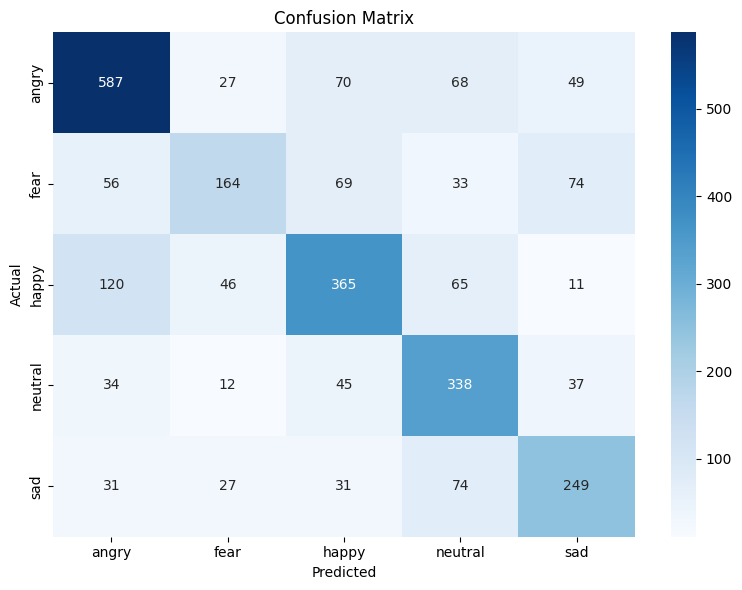

In [ ]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, cohen_kappa_score,
                             matthews_corrcoef, log_loss, roc_auc_score, precision_recall_fscore_support)
from sklearn.preprocessing import label_binarize
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

# Accuracy, Precision, Recall, F1 (weighted)
acc = accuracy_score(y_true, y_pred)
prec_w = precision_score(y_true, y_pred, average='weighted')
rec_w = recall_score(y_true, y_pred, average='weighted')
f1_w = f1_score(y_true, y_pred, average='weighted')

# Macro / Micro
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
prec_micro, rec_micro, f1_micro, _ = precision_recall_fscore_support(y_true, y_pred, average='micro')

# Advanced metrics
kappa = cohen_kappa_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)
logloss = log_loss(y_true, y_pred_probs)

# ROC AUC
y_true_bin = label_binarize(y_true, classes=range(len(label_encoder.classes_)))
roc_auc = roc_auc_score(y_true_bin, y_pred_probs, average='macro', multi_class='ovr')

# Print summary
print(f"✅ Accuracy:            {acc:.4f}")
print(f"✅ Precision (weighted):{prec_w:.4f}")
print(f"✅ Recall (weighted):   {rec_w:.4f}")
print(f"✅ F1 Score (weighted): {f1_w:.4f}")
print()
print(f"📊 Macro Precision:     {prec_macro:.4f}")
print(f"📊 Micro Precision:     {prec_micro:.4f}")
print(f"📊 Cohen's Kappa:       {kappa:.4f}")
print(f"📊 Matthews Corrcoef:   {mcc:.4f}")
print(f"📊 Log Loss:            {logloss:.4f}")
print(f"📊 ROC AUC (macro):     {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
target_names = label_encoder.classes_
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

Integrating HMM

In [ ]:
#!pip install hmmlearn
!pip install --upgrade hmmlearn

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np

# Load padded validation data
X_val = np.load("/content/drive/MyDrive/EmotionFeaturesProcessed/X_val_padded.npy")

# Load your trained model
model = load_model("/content/drive/MyDrive/EmotionFeaturesProcessed/best_lstm_model.keras")  # or .h5

# Predict softmax probabilities
softmax_val = model.predict(X_val)  # Shape: (samples, num_classes)

# Save for HMM usage
np.save("/content/drive/MyDrive/EmotionFeaturesProcessed/softmax_val.npy", softmax_val)

PREPARE GROUND TRUTH FOR HMM EVALUATION

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Load raw emotion labels
y_all = np.load("/content/drive/MyDrive/EmotionFeaturesProcessed/y_all.npy", allow_pickle=True)

# If you had already split X_train and X_val, then split y_all the same way
# Make sure you split the same way as you split x_all into x_train/x_val
# For now, let's assume you have the correct validation labels in raw form
# Let's encode them (if not already done)

label_encoder = LabelEncoder()
y_all_encoded = label_encoder.fit_transform(y_all)  # e.g., 'happy' -> 2, etc.

# Save encoder for later use
import pickle
with open("/content/drive/MyDrive/EmotionFeaturesProcessed/label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

# Assuming val indices are known (say, last 20%)
val_ratio = 0.2
split_index = int(len(y_all_encoded) * (1 - val_ratio))
y_val_encoded = y_all_encoded[split_index:]  # adjust if needed

np.save("/content/drive/MyDrive/EmotionFeaturesProcessed/y_val_encoded.npy", y_val_encoded)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load the encoder used during training
import pickle
with open("/content/drive/MyDrive/EmotionFeaturesProcessed/label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_hmm)

# Plot with emotion labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted Emotion")
plt.ylabel("True Emotion")
plt.title("HMM Confusion Matrix with Emotion Labels")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
with open("/content/drive/MyDrive/EmotionFeaturesProcessed/label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

print("Classes:", le.classes_)

In [ ]:
# HDF5 is a old version format for saving models
from tensorflow.keras.models import load_model

# Load the old HDF5 model
model = load_model("/content/drive/MyDrive/EmotionFeaturesProcessed/best_lstm_model.h5")

# Save it in new Keras format
model.save("/content/drive/MyDrive/EmotionFeaturesProcessed/best_lstm_model.keras")

LSTM + HMM MODEL

Epoch 1/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3158 - loss: 1.5098
Epoch 1: val_loss improved from inf to 1.33211, saving model to /content/drive/MyDrive/EmotionFeaturesProcessed/best_lstm_model2.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.3160 - loss: 1.5094 - val_accuracy: 0.4467 - val_loss: 1.3321
Epoch 2/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4754 - loss: 1.2735
Epoch 2: val_loss improved from 1.33211 to 1.13378, saving model to /content/drive/MyDrive/EmotionFeaturesProcessed/best_lstm_model2.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.4756 - loss: 1.2732 - val_accuracy: 0.5384 - val_loss: 1.1338
Epoch 3/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5628 - loss: 1.1140
Epoch 3: val_loss improved from 1.13378 to 1.09606, saving model to /content/drive/MyDrive/EmotionFeaturesProcessed/best_lstm_model2.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.5628 - loss: 1.1139 - val_accuracy: 0.55

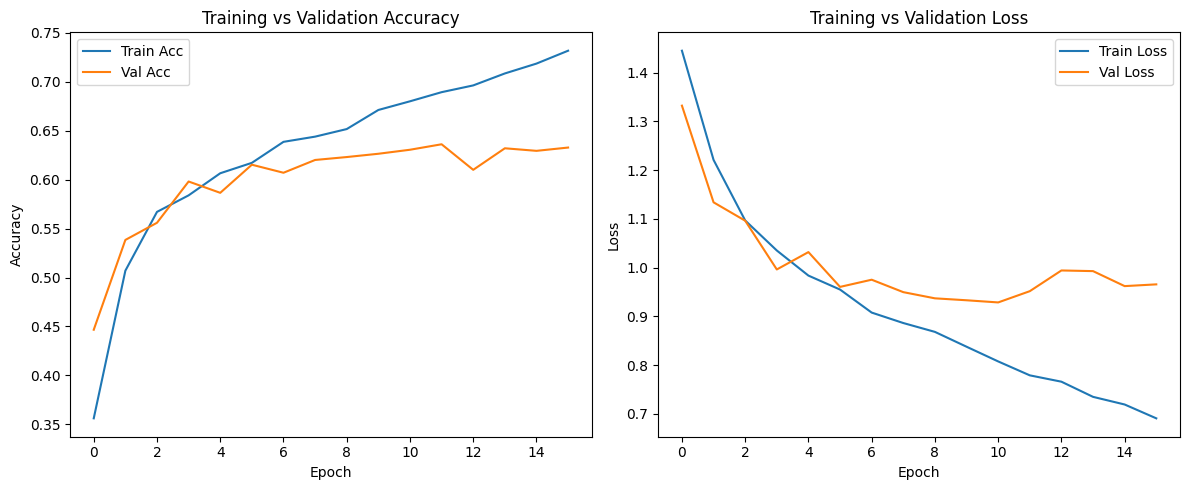

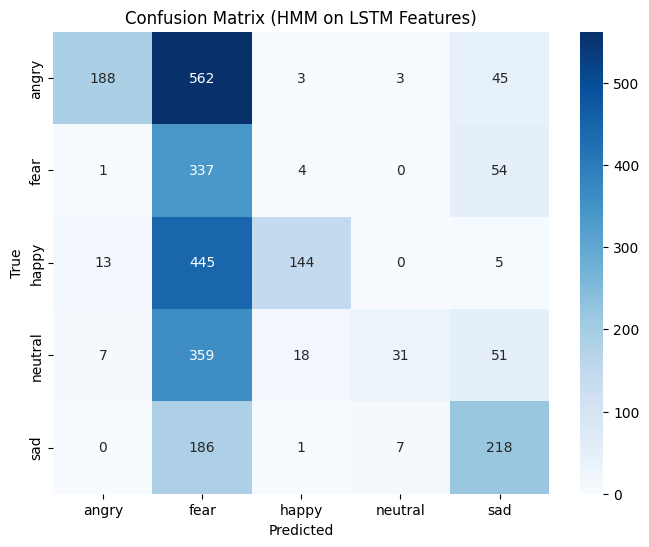

              precision    recall  f1-score   support

       angry     0.8995    0.2347    0.3723       801
        fear     0.1784    0.8510    0.2950       396
       happy     0.8471    0.2372    0.3707       607
     neutral     0.7561    0.0665    0.1223       466
         sad     0.5845    0.5291    0.5554       412

    accuracy                         0.3423      2682
   macro avg     0.6531    0.3837    0.3431      2682
weighted avg     0.7079    0.3423    0.3452      2682

Prediction Distribution: Counter({np.str_('fear'): 1889, np.str_('sad'): 373, np.str_('angry'): 209, np.str_('happy'): 170, np.str_('neutral'): 41})


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, TimeDistributed
from tensorflow.keras.layers import GlobalAveragePooling1D # Import the pooling layer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from hmmlearn import hmm
from collections import Counter

# === LOAD PADDED FEATURES AND LABELS ===
X = np.load("/content/drive/MyDrive/EmotionFeaturesProcessed/X_all_padded.npy", allow_pickle=True)
y = np.load("/content/drive/MyDrive/EmotionFeaturesProcessed/y_all.npy", allow_pickle=True)

# === ENCODE EMOTION LABELS ===
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# === TRAIN/VALIDATION SPLIT ===
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# === ONE-HOT ENCODING FOR LSTM TRAINING ===
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_val_cat = to_categorical(y_val, num_classes=num_classes)

# === DEFINE LSTM MODEL ===
input_shape = X.shape[1:]
input_layer = Input(shape=input_shape)
x = LSTM(128, return_sequences=True)(input_layer)
x = Dropout(0.3)(x)
x = TimeDistributed(Dense(64, activation='relu'))(x)
x = Dropout(0.3)(x)
x = TimeDistributed(Dense(32, activation='relu'))(x) # Add a third TimeDistributed Dense layer
x = GlobalAveragePooling1D()(x) # Add Global Average Pooling layer
output_layer = Dense(num_classes, activation='softmax')(x) # Final Dense layer for classification
lstm_model = Model(inputs=input_layer, outputs=output_layer)

# === COMPILE MODEL ===
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# === CALLBACKS ===
checkpoint_path = "/content/drive/MyDrive/EmotionFeaturesProcessed/best_lstm_model2.keras"
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(
    checkpoint_path, monitor='val_loss', save_best_only=True,
    save_weights_only=False, verbose=1
)
callbacks = [early_stop, checkpoint]

# === TRAIN THE LSTM ===
history = lstm_model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=30,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# === CREATE FEATURE EXTRACTOR (Penultimate Layer before pooling) ===
# Update the layer index to be before the GlobalAveragePooling1D layer
feature_extractor = Model(inputs=lstm_model.input, outputs=lstm_model.layers[-3].output) # Get output of last TimeDistributed layer


# === MAKE SURE LSTM MODEL IS CALLED BEFORE USING feature_extractor ===
# The model is already built after training, so this line is not strictly necessary here.
# _ = lstm_model.predict(X_train[:1])  # call model once to build it

# === EXTRACT LSTM SEQUENCE FEATURES ===
lstm_features_train = feature_extractor.predict(X_train, verbose=0)
lstm_features_val = feature_extractor.predict(X_val, verbose=0)

# === TRAIN HMM PER CLASS ===
def train_hmm_models(X_seq, y_seq, n_components=4):
    models = {}
    for class_idx in np.unique(y_seq):
        class_sequences = [x for x, y in zip(X_seq, y_seq) if y == class_idx]
        # Ensure lengths are calculated correctly for each sequence
        lengths = [len(seq) for seq in class_sequences]
        # Concatenate all sequences for the class
        X_concat = np.concatenate(class_sequences, axis=0)
        if X_concat.shape[0] == 0: # Handle empty classes if any
          print(f"Warning: No data for class {class_idx}")
          continue

        hmm_model = hmm.GaussianHMM(n_components=n_components, covariance_type="diag", n_iter=1000, random_state=42)
        hmm_model.fit(X_concat, lengths)
        models[class_idx] = hmm_model
    return models

hmm_models = train_hmm_models(lstm_features_train, y_train)

# === HMM PREDICTION ===
def predict_with_hmm(models, X_seq):
    predictions = []
    # Retrieve the original label encoder to map back to emotion names
    # Assuming the label_encoder object is still available in the environment or can be reloaded
    # If not, you'd need to save/load it. For this script, assuming it's available.
    # If not available, you would use class indices directly.
    class_indices = list(models.keys()) # Get the trained class indices

    for seq in X_seq:
        scores = {cls: models[cls].score(seq) for cls in class_indices}
        # Find the class index with the maximum score
        pred_class_idx = max(scores, key=scores.get)
        predictions.append(pred_class_idx)
    # Convert predicted indices back to original labels if needed for reporting
    # This would require the label_encoder.
    # For now, we return the indices which work with sklearn.metrics
    return np.array(predictions)

hmm_preds = predict_with_hmm(hmm_models, lstm_features_val)

# === EVALUATION ===
# Use the original y_val (encoded integer labels) for evaluation
report = classification_report(y_val, hmm_preds, target_names=label_encoder.classes_, digits=4)
conf_mat = confusion_matrix(y_val, hmm_preds)
# Use label_encoder to get the actual class names for Counter
prediction_labels = label_encoder.inverse_transform(hmm_preds)
prediction_dist = Counter(prediction_labels)


# === PLOT LEARNING CURVES ===
def plot_learning_curves(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

# === PLOT CONFUSION MATRIX ===
def plot_confusion_matrix(conf_mat, class_labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (HMM on LSTM Features)")
    plt.show()

plot_learning_curves(history)
plot_confusion_matrix(conf_mat, label_encoder.classes_)

# === FINAL OUTPUT ===
print(report)
print("Prediction Distribution:", prediction_dist)

IMPROVEMENT-----------------

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, TimeDistributed, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from hmmlearn.hmm import GMMHMM
from collections import Counter

# === LOAD PADDED FEATURES AND LABELS ===
X = np.load("/content/drive/MyDrive/EmotionFeaturesProcessed/X_all_padded.npy", allow_pickle=True)
y = np.load("/content/drive/MyDrive/EmotionFeaturesProcessed/y_all.npy", allow_pickle=True)

# === ENCODE EMOTION LABELS ===
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# === TRAIN/VALIDATION SPLIT ===
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# === ONE-HOT ENCODING FOR LSTM TRAINING ===
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_val_cat = to_categorical(y_val, num_classes=num_classes)

# === DEFINE LSTM MODEL ===
input_shape = X.shape[1:]
input_layer = Input(shape=input_shape)
x = LSTM(128, return_sequences=True)(input_layer)
x = Dropout(0.3)(x)
x = TimeDistributed(Dense(64, activation='relu'))(x)
x = Dropout(0.3)(x)
x = TimeDistributed(Dense(32, activation='relu'))(x)
x = GlobalAveragePooling1D()(x)
output_layer = Dense(num_classes, activation='softmax')(x)
lstm_model = Model(inputs=input_layer, outputs=output_layer)

# === COMPILE MODEL ===
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# === CALLBACKS ===
checkpoint_path = "/content/drive/MyDrive/EmotionFeaturesProcessed/best_lstm_model2.keras"
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(
    checkpoint_path, monitor='val_loss', save_best_only=True,
    save_weights_only=False, verbose=1
)
callbacks = [early_stop, checkpoint]

# === TRAIN THE LSTM ===
history = lstm_model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=30,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# === CREATE FEATURE EXTRACTOR ===
feature_extractor = Model(inputs=lstm_model.input, outputs=lstm_model.layers[-3].output)

# === EXTRACT LSTM SEQUENCE FEATURES ===
lstm_features_train = feature_extractor.predict(X_train, verbose=0)
lstm_features_val = feature_extractor.predict(X_val, verbose=0)

# === SCALE FEATURES FOR HMM ===
def scale_sequence_features(feature_sequences):
    all_data = np.concatenate(feature_sequences, axis=0)
    scaler = StandardScaler()
    scaler.fit(all_data)
    return [scaler.transform(seq) for seq in feature_sequences], scaler

lstm_features_train_scaled, scaler = scale_sequence_features(lstm_features_train)
lstm_features_val_scaled = [scaler.transform(seq) for seq in lstm_features_val]

# === TRAIN GMM-HMM MODELS ===
def train_gmmhmm_models(X_seq, y_seq, n_components=4, n_mix=3):
    models = {}
    for class_idx in np.unique(y_seq):
        class_sequences = [x for x, y in zip(X_seq, y_seq) if y == class_idx]
        if not class_sequences:
            print(f"⚠️ No sequences found for class {class_idx}. Skipping.")
            continue
        lengths = [len(seq) for seq in class_sequences]
        X_concat = np.concatenate(class_sequences, axis=0)
        hmm_model = GMMHMM(
            n_components=n_components,
            n_mix=n_mix,
            covariance_type="diag",
            n_iter=1000,
            random_state=42,
            verbose=True
        )
        try:
            hmm_model.fit(X_concat, lengths)
            models[class_idx] = hmm_model
        except Exception as e:
            print(f"❌ Failed to train HMM for class {class_idx}: {e}")
    return models

hmm_models = train_gmmhmm_models(lstm_features_train_scaled, y_train)

# === PREDICT WITH HMM ===
def predict_with_hmm(models, X_seq):
    predictions = []
    for seq in X_seq:
        scores = {cls: model.score(seq) for cls, model in models.items()}
        best_class = max(scores, key=scores.get)
        predictions.append(best_class)
    return np.array(predictions)

hmm_preds = predict_with_hmm(hmm_models, lstm_features_val_scaled)

# === EVALUATION ===
report = classification_report(y_val, hmm_preds, target_names=label_encoder.classes_, digits=4)
conf_mat = confusion_matrix(y_val, hmm_preds)
prediction_labels = label_encoder.inverse_transform(hmm_preds)
prediction_dist = Counter(prediction_labels)

# === PLOT LEARNING CURVES ===
def plot_learning_curves(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

# === PLOT CONFUSION MATRIX ===
def plot_confusion_matrix(conf_mat, class_labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (HMM on LSTM Features)")
    plt.show()

plot_learning_curves(history)
plot_confusion_matrix(conf_mat, label_encoder.classes_)

# === PRINT RESULTS ===
print(report)
print("Prediction Distribution:", prediction_dist)

Epoch 1/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3133 - loss: 1.4942
Epoch 1: val_loss improved from inf to 1.27969, saving model to /content/drive/MyDrive/EmotionFeaturesProcessed/best_lstm_model2.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 252s 1s/step - accuracy: 0.3136 - loss: 1.4937 - val_accuracy: 0.4866 - val_loss: 1.2797
Epoch 2/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4830 - loss: 1.2550
Epoch 2: val_loss improved from 1.27969 to 1.14112, saving model to /content/drive/MyDrive/EmotionFeaturesProcessed/best_lstm_model2.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.4831 - loss: 1.2548 - val_accuracy: 0.5242 - val_loss: 1.1411
Epoch 3/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5493 - loss: 1.1193
Epoch 3: val_loss improved from 1.14112 to 1.04578, saving model to /content/drive/MyDrive/EmotionFeaturesProcessed/best_lstm_model2.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.5493 - loss: 1.1191 - val_accuracy: 0.56

         1 -26647628.60679834             +nan
/usr/local/lib/python3.11/dist-packages/hmmlearn/utils.py:55: RuntimeWarning: invalid value encountered in subtract
  a -= a_lse
         2 12154559.79346159 +38802188.40025993
         3              nan             +nan
         4              nan             +nan
         5              nan             +nan
         6              nan             +nan
         7              nan             +nan
         8              nan             +nan
         9              nan             +nan
        10              nan             +nan
        11              nan             +nan
        12              nan             +nan
        13              nan             +nan


KeyboardInterrupt: 

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, GlobalAveragePooling1D, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from hmmlearn import hmm
from collections import Counter
import os

# === LOAD PADDED DATA ===
X = np.load("/content/drive/MyDrive/EmotionFeaturesProcessed/X_all_padded.npy", allow_pickle=True)
y = np.load("/content/drive/MyDrive/EmotionFeaturesProcessed/y_all.npy", allow_pickle=True)

# === LABEL ENCODING ===
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# === SPLIT DATA ===
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# === ONE-HOT ENCODING FOR LSTM TRAINING ===
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)

# === DEFINE LSTM MODEL ===
input_shape = X.shape[1:]  # (timesteps, features)
lstm_model = Sequential([
    Input(shape=input_shape),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    TimeDistributed(Dense(64, activation='relu')),
    Dropout(0.3),
    TimeDistributed(Dense(32, activation='relu')),
    GlobalAveragePooling1D(),
    Dense(num_classes, activation='softmax')
])

lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# === TRAINING CALLBACKS ===
checkpoint_path = "/content/drive/MyDrive/EmotionFeaturesProcessed/best_lstm_model2.keras"
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)
]

# === TRAIN LSTM ===
history = lstm_model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=30,
    batch_size=32,
    callbacks=callbacks
)

# === FEATURE EXTRACTOR MODEL (before pooling) ===
feature_extractor = Model(inputs=lstm_model.input, outputs=lstm_model.layers[4].output)  # Output of second TimeDistributed

# === GET SEQUENCE-LEVEL FEATURES FOR HMM ===
lstm_features_train = feature_extractor.predict(X_train)
lstm_features_val = feature_extractor.predict(X_val)

# === TRAIN HMM MODELS PER EMOTION ===
def train_hmm_models(X_seq, y_seq, n_components=4):
    models = {}
    for class_idx in np.unique(y_seq):
        class_sequences = [x for x, y in zip(X_seq, y_seq) if y == class_idx]
        lengths = [len(seq) for seq in class_sequences]
        X_concat = np.concatenate(class_sequences, axis=0)
        hmm_model = hmm.GaussianHMM(n_components=n_components, covariance_type="diag", n_iter=1000)
        hmm_model.fit(X_concat, lengths)
        models[class_idx] = hmm_model
    return models

hmm_models = train_hmm_models(lstm_features_train, y_train)

# === HMM PREDICTION ===
def predict_with_hmm(models, X_seq):
    predictions = []
    for seq in X_seq:
        scores = {cls: model.score(seq) for cls, model in models.items()}
        pred = max(scores, key=scores.get)
        predictions.append(pred)
    return np.array(predictions)

hmm_preds = predict_with_hmm(hmm_models, lstm_features_val)

# === EVALUATION ===
report = classification_report(y_val, hmm_preds, target_names=label_encoder.classes_, digits=4)
conf_mat = confusion_matrix(y_val, hmm_preds)
prediction_dist = Counter(hmm_preds)

print("\n📊 Classification Report (HMM on LSTM outputs):")
print(report)
print("\n🔢 Confusion Matrix:")
print(conf_mat)
print("\n📈 Prediction Distribution:")
print(prediction_dist)

Feature....

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example path to one file (update this if I want a different one)
file_path = "/content/unzipped_extracted_features_TESS/TESS Toronto emotional speech set data/OAF_neutral/OAF_date_neutral.npy"

# Load the features
features = np.load(file_path)

# Inspect
print("Shape:", features.shape)
print("Sample values:\n", features)

UZIPPING A FOLDER FROM MY DRIVE

In [ ]:
import os
import zipfile

zip_dir = "/content/drive/MyDrive/LSTM_ALL_NPYFEATURES"

for file in os.listdir(zip_dir):
    if file.endswith(".zip"):
        zip_path = os.path.join(zip_dir, file)
        extract_folder = os.path.join(zip_dir, file.replace(".zip", ""))

        print(f"📦 Unzipping {file} → {extract_folder}")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_folder)

PADDING X_all

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the raw sequences
X_all = np.load("/content/drive/MyDrive/EmotionFeaturesProcessed/X_all.npy", allow_pickle=True)

# Determine the max length from training/validation data (or choose a fixed one, e.g., 200)
# If unsure, you can set it based on max length in x_all
max_len = 269

# Pad all sequences to the same length
X_all_padded = pad_sequences(X_all, maxlen=max_len, padding='post', dtype='float32')

# Save the padded data
np.save("/content/drive/MyDrive/EmotionFeaturesProcessed/X_all_padded.npy", X_all_padded)

print(f"✅ Saved padded data to x_all_padded.npy with shape: {X_all_padded.shape}")

✅ Saved padded data to x_all_padded.npy with shape: (13406, 269, 26)


CONFIRMING MAX LENGTH OF X_train_padded

In [ ]:
import numpy as np

# Load the already padded training data
X_train_padded = np.load("/content/drive/MyDrive/EmotionFeaturesProcessed/X_train_padded.npy", allow_pickle=True)

# Check shape
print("📐 x_train_padded shape:", X_train_padded.shape)

# Extract the time-step length
max_len_used = X_train_padded.shape[1]
print("✅ Original max_len used for padding:", max_len_used)

📐 x_train_padded shape: (10724, 269, 26)
✅ Original max_len used for padding: 269


TO CONFIRM THE CORRECT ORDER OF EMOTIONS

In [ ]:
import joblib
le = joblib.load("/content/drive/MyDrive/EmotionFeaturesProcessed/label_encoder.pkl")
print(le.classes_)  # Gives: ['Angry', 'Fear', 'Happy', 'Neutral', 'Sad']

['angry' 'fear' 'happy' 'neutral' 'sad']


I HOPE THIS DOES WELL

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define paths for the data files
X_train_path = '/content/drive/MyDrive/EmotionFeaturesProcessed/X_train_padded.npy'
X_val_path = '/content/drive/MyDrive/EmotionFeaturesProcessed/X_val_padded.npy'
y_train_path = '/content/drive/MyDrive/EmotionFeaturesProcessed/y_train_onehot.npy'
y_val_path = '/content/drive/MyDrive/EmotionFeaturesProcessed/y_val_onehot.npy'

# Load the data from the specified paths
X_train = np.load(X_train_path)
X_val = np.load(X_val_path)
y_train = np.load(y_train_path)
y_val = np.load(y_val_path)


# Define model
model = Sequential([
    Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
es = EarlyStopping(patience=7, restore_best_weights=True)
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32, callbacks=[es])

# Predict
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

# Evaluation
print(classification_report(y_true, y_pred))
print("Accuracy:", accuracy_score(y_true, y_pred))

# HMM --------------------------------------------------------------------------------
from hmmlearn.hmm import GaussianHMM

# Flatten sequences for HMM
X_flat = X_train.reshape(-1, X_train.shape[2])
lengths = [X_train.shape[1]] * X_train.shape[0]

# HMM assumes continuous states, so train per class
hmms = []
for i in range(y_train.shape[1]):
    indices = np.argmax(y_train, axis=1) == i
    data = X_train[indices].reshape(-1, X_train.shape[2])
    lengths_i = [X_train.shape[1]] * np.sum(indices)
    hmm = GaussianHMM(n_components=5, covariance_type='diag', n_iter=100)
    hmm.fit(data, lengths_i)
    hmms.append(hmm)

# Predict
def predict_hmm(X):
    preds = []
    for x in X:
        scores = [model.score(x) for model in hmms]
        preds.append(np.argmax(scores))
    return np.array(preds)

hmm_preds = predict_hmm(X_val)
print(classification_report(y_true, hmm_preds))
print("HMM Accuracy:", accuracy_score(y_true, hmm_preds))

# HYBRID --------------------------------------------------------------------------

# Use HMM predicted states as additional features
def append_hmm_states(X, hmms):
    X_aug = []
    for x in X:
        scores = [model.score(x) for model in hmms]
        X_aug.append(np.hstack((x, np.tile(scores, (x.shape[0], 1)))))
    return np.array(X_aug)

X_train_hybrid = append_hmm_states(X_train, hmms)
X_val_hybrid = append_hmm_states(X_val, hmms)

# Build LSTM with hybrid input
hybrid_model = Sequential([
    Masking(mask_value=0., input_shape=(X_train_hybrid.shape[1], X_train_hybrid.shape[2])),
    LSTM(128),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

hybrid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hybrid_model.fit(X_train_hybrid, y_train, validation_data=(X_val_hybrid, y_val), epochs=30, batch_size=32, callbacks=[es])

# Evaluate hybrid model
y_hybrid_probs = hybrid_model.predict(X_val_hybrid)
y_hybrid_pred = np.argmax(y_hybrid_probs, axis=1)

print(classification_report(y_true, y_hybrid_pred))
print("Hybrid Accuracy:", accuracy_score(y_true, y_hybrid_pred))

TOOOOOOOOOOOOR

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn.hmm import GaussianHMM

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define paths for the data files
X_train_path = '/content/drive/MyDrive/EmotionFeaturesProcessed/X_train_padded.npy'
X_val_path = '/content/drive/MyDrive/EmotionFeaturesProcessed/X_val_padded.npy'
y_train_path = '/content/drive/MyDrive/EmotionFeaturesProcessed/y_train_onehot.npy'
y_val_path = '/content/drive/MyDrive/EmotionFeaturesProcessed/y_val_onehot.npy'

# Load the data
X_train = np.load(X_train_path)
X_val = np.load(X_val_path)
y_train = np.load(y_train_path)
y_val = np.load(y_val_path)

# ------------------ LSTM Model ------------------

model = Sequential([
    Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(patience=7, restore_best_weights=True)
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32, callbacks=[es])

y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

print("=== LSTM Evaluation ===")
print(classification_report(y_true, y_pred))
print("LSTM Accuracy:", accuracy_score(y_true, y_pred))

# ------------------ HMM Model ------------------

# Check for NaNs or Infs
assert not np.isnan(X_train).any(), "NaNs in X_train"
assert not np.isinf(X_train).any(), "Infs in X_train"

# Class distribution
unique, counts = np.unique(np.argmax(y_train, axis=1), return_counts=True)
print("Class distribution:", dict(zip(unique, counts)))

# Train HMM per class
hmms = []
min_required_sequences = 5
for i in range(y_train.shape[1]):
    indices = np.argmax(y_train, axis=1) == i
    count = np.sum(indices)

    if count < min_required_sequences:
        print(f"Skipping class {i}: only {count} sequences.")
        hmms.append(None)
        continue

    data = X_train[indices].reshape(-1, X_train.shape[2])
    lengths_i = [X_train.shape[1]] * count

    if np.isnan(data).any() or np.isinf(data).any():
        print(f"Skipping class {i}: NaNs or Infs in data.")
        hmms.append(None)
        continue

    try:
        hmm = GaussianHMM(n_components=3, covariance_type='diag', n_iter=100, random_state=42)
        hmm.fit(data, lengths_i)
        if np.isnan(hmm.startprob_).any() or not np.isclose(hmm.startprob_.sum(), 1.0):
            print(f"Invalid startprob_ for class {i}.")
            hmms.append(None)
            continue
        hmms.append(hmm)
    except Exception as e:
        print(f"Error fitting HMM for class {i}: {e}")
        hmms.append(None)

# Predict using HMMs
def predict_hmm(X):
    preds = []
    for x in X:
        scores = []
        for hmm in hmms:
            if hmm is None:
                scores.append(float('-inf'))
            else:
                try:
                    scores.append(hmm.score(x))
                except Exception as e:
                    print(f"HMM scoring error: {e}")
                    scores.append(float('-inf'))
        preds.append(np.argmax(scores))
    return np.array(preds)

hmm_preds = predict_hmm(X_val)
print("\n=== HMM Evaluation ===")
print(classification_report(y_true, hmm_preds))
print("HMM Accuracy:", accuracy_score(y_true, hmm_preds))

# ------------------ Hybrid Model ------------------

def append_hmm_states(X, hmms):
    X_aug = []
    for x in X:
        scores = []
        for hmm in hmms:
            if hmm is None:
                scores.append(0)
            else:
                try:
                    scores.append(hmm.score(x))
                except:
                    scores.append(0)
        x_aug = np.hstack((x, np.tile(scores, (x.shape[0], 1))))
        X_aug.append(x_aug)
    return np.array(X_aug)

X_train_hybrid = append_hmm_states(X_train, hmms)
X_val_hybrid = append_hmm_states(X_val, hmms)

hybrid_model = Sequential([
    Masking(mask_value=0., input_shape=(X_train_hybrid.shape[1], X_train_hybrid.shape[2])),
    LSTM(128),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

hybrid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hybrid_model.fit(X_train_hybrid, y_train, validation_data=(X_val_hybrid, y_val), epochs=30, batch_size=32, callbacks=[es])

y_hybrid_probs = hybrid_model.predict(X_val_hybrid)
y_hybrid_pred = np.argmax(y_hybrid_probs, axis=1)

print("\n=== Hybrid Model Evaluation ===")
print(classification_report(y_true, y_hybrid_pred))
print("Hybrid Accuracy:", accuracy_score(y_true, y_hybrid_pred))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
336/336 ━━━━━━━━━━━━━━━━━━━━ 161s 466ms/step - accuracy: 0.2913 - loss: 1.5735 - val_accuracy: 0.3919 - val_loss: 1.4243
Epoch 2/30
336/336 ━━━━━━━━━━━━━━━━━━━━ 206s 479ms/step - accuracy: 0.3551 - loss: 1.4469 - val_accuracy: 0.4318 - val_loss: 1.3663
Epoch 3/30
336/336 ━━━━━━━━━━━━━━━━━━━━ 209s 500ms/step - accuracy: 0.3706 - loss: 1.4095 - val_accuracy: 0.4463 - val_loss: 1.3264
Epoch 4/30
336/336 ━━━━━━━━━━━━━━━━━━━━ 169s 503ms/step - accuracy: 0.3998 - loss: 1.3762 - val_accuracy: 0.4515 - val_loss: 1.2998
Epoch 5/30
336/336 ━━━━━━━━━━━━━━━━━━━━ 205s 511ms/step - accuracy: 0.4172 - loss: 1.3479 - val_accuracy: 0.4940 - val_loss: 1.2562
Epoch 6/30
336/336 ━━━━━━━━━━━━━━━━━━━━ 165s 492ms/step - accuracy: 0.4423 - loss: 1.3191 - val_accuracy: 0.5101 - val_loss: 1.2281
Epoch 7/30
336/336 ━━━━━━━━━━━━━━━━━━━━ 161s 478ms/step - accuracy: 0.4451 - loss: 1.3047 - val_accuracy: 0.5261 - val_loss: 1.1963
Epoch 8/30
336/336 ━━━━━━━━━━━━━━━━━━━━ 163s 485ms/step - accuracy: 0.4605 -

/usr/local/lib/python3.11/dist-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])


Invalid startprob_ for class 2.


/usr/local/lib/python3.11/dist-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])


Invalid startprob_ for class 3.


/usr/local/lib/python3.11/dist-packages/hmmlearn/hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])


Invalid startprob_ for class 4.

=== HMM Evaluation ===
              precision    recall  f1-score   support

           0       0.28      0.14      0.19       801
           1       0.16      0.93      0.28       396
           2       0.00      0.00      0.00       607
           3       0.00      0.00      0.00       466
           4       0.00      0.00      0.00       412

    accuracy                           0.18      2682
   macro avg       0.09      0.22      0.09      2682
weighted avg       0.11      0.18      0.10      2682

HMM Accuracy: 0.18046234153616703


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Epoch 1/30
336/336 ━━━━━━━━━━━━━━━━━━━━ 173s 497ms/step - accuracy: 0.2600 - loss: 1.6232 - val_accuracy: 0.3028 - val_loss: 1.5484
Epoch 2/30
336/336 ━━━━━━━━━━━━━━━━━━━━ 207s 513ms/step - accuracy: 0.2777 - loss: 1.5713 - val_accuracy: 0.3054 - val_loss: 1.5557
Epoch 3/30
336/336 ━━━━━━━━━━━━━━━━━━━━ 208s 531ms/step - accuracy: 0.2942 - loss: 1.5672 - val_accuracy: 0.3043 - val_loss: 1.5518
Epoch 4/30
336/336 ━━━━━━━━━━━━━━━━━━━━ 171s 508ms/step - accuracy: 0.2901 - loss: 1.5619 - val_accuracy: 0.2987 - val_loss: 1.5517
Epoch 5/30
336/336 ━━━━━━━━━━━━━━━━━━━━ 168s 500ms/step - accuracy: 0.2922 - loss: 1.5659 - val_accuracy: 0.3110 - val_loss: 1.5552
Epoch 6/30
336/336 ━━━━━━━━━━━━━━━━━━━━ 175s 521ms/step - accuracy: 0.2942 - loss: 1.5655 - val_accuracy: 0.3102 - val_loss: 1.5514
Epoch 7/30
336/336 ━━━━━━━━━━━━━━━━━━━━ 199s 512ms/step - accuracy: 0.3010 - loss: 1.5582 - val_accuracy: 0.3076 - val_loss: 1.5510
Epoch 8/30
336/336 ━━━━━━━━━━━━━━━━━━━━ 203s 514ms/step - accuracy: 0.2967 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ANOTHER.....

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score
from hmmlearn.hmm import GaussianHMM
from scipy.special import softmax
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

# Load data
X_train = np.load('/content/drive/MyDrive/EmotionFeaturesProcessed/X_train_padded.npy')
X_val = np.load('/content/drive/MyDrive/EmotionFeaturesProcessed/X_val_padded.npy')
y_train = np.load('/content/drive/MyDrive/EmotionFeaturesProcessed/y_train_onehot.npy')
y_val = np.load('/content/drive/MyDrive/EmotionFeaturesProcessed/y_val_onehot.npy')

# ---------------------- LSTM Model ----------------------
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    Masking(mask_value=0.),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(patience=7, restore_best_weights=True)
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32, callbacks=[es])

y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

print("=== LSTM Evaluation ===")
print(classification_report(y_true, y_pred))
print("LSTM Accuracy:", accuracy_score(y_true, y_pred))


# ---------------------- HMM Model ----------------------

# Utility: Remove zero-padding
def unpad_sequence(seq):
    return seq[~np.all(seq == 0, axis=1)]

# Utility: Normalize per sequence
def normalize_sequence(seq):
    mean = np.mean(seq, axis=0)
    std = np.std(seq, axis=0) + 1e-6
    return (seq - mean) / std

# Build HMMs per class
hmms = []
num_classes = y_train.shape[1]
for i in range(num_classes):
    indices = np.argmax(y_train, axis=1) == i
    sequences = X_train[indices]

    # Clean and normalize sequences
    cleaned = []
    lengths = []
    for seq in sequences:
        unpadded = unpad_sequence(seq)
        if unpadded.shape[0] > 10:  # discard very short sequences
            normalized = normalize_sequence(unpadded)
            cleaned.append(normalized)
            lengths.append(len(normalized))

    if len(cleaned) < 5:
        print(f"Skipping class {i}: only {len(cleaned)} usable sequences.")
        hmms.append(None)
        continue

    data = np.concatenate(cleaned, axis=0)

    try:
        hmm = GaussianHMM(n_components=4, covariance_type='diag', n_iter=200, random_state=42)
        hmm.fit(data, lengths)
        if np.isnan(hmm.startprob_).any() or not np.isclose(hmm.startprob_.sum(), 1.0):
            print(f"Invalid startprob_ for class {i}.")
            hmms.append(None)
        else:
            hmms.append(hmm)
    except Exception as e:
        print(f"Failed training HMM for class {i}: {e}")
        hmms.append(None)

# Predict using HMMs
def predict_hmm(X, hmms):
    preds = []
    for seq in X:
        unpadded = unpad_sequence(seq)
        norm = normalize_sequence(unpadded)
        scores = []
        for hmm in hmms:
            if hmm is None:
                scores.append(-1e9)
            else:
                try:
                    scores.append(hmm.score(norm))
                except:
                    scores.append(-1e9)
        scores = softmax(scores)
        preds.append(np.argmax(scores))
    return np.array(preds)

hmm_preds = predict_hmm(X_val, hmms)
print("\n=== HMM Evaluation ===")
print(classification_report(y_true, hmm_preds))
print("HMM Accuracy:", accuracy_score(y_true, hmm_preds))


# ---------------------- Hybrid Model ----------------------

def append_hmm_scores(X, hmms):
    augmented = []
    for seq in X:
        unpadded = unpad_sequence(seq)
        norm = normalize_sequence(unpadded)
        scores = []
        for hmm in hmms:
            if hmm is None:
                scores.append(-1e9)
            else:
                try:
                    scores.append(hmm.score(norm))
                except:
                    scores.append(-1e9)
        scores = softmax(scores)
        # Append scores to each frame
        scores_tiled = np.tile(scores, (seq.shape[0], 1))
        augmented.append(np.concatenate([seq, scores_tiled], axis=-1))
    return np.array(augmented)

X_train_hybrid = append_hmm_scores(X_train, hmms)
X_val_hybrid = append_hmm_scores(X_val, hmms)

hybrid_model = Sequential([
    Input(shape=(X_train_hybrid.shape[1], X_train_hybrid.shape[2])),
    Masking(mask_value=0.),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

hybrid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hybrid_model.fit(X_train_hybrid, y_train, validation_data=(X_val_hybrid, y_val), epochs=30, batch_size=32, callbacks=[es])

y_hybrid_probs = hybrid_model.predict(X_val_hybrid)
y_hybrid_pred = np.argmax(y_hybrid_probs, axis=1)

print("\n=== Hybrid Model Evaluation ===")
print(classification_report(y_true, y_hybrid_pred))
print("Hybrid Accuracy:", accuracy_score(y_true, y_hybrid_pred))

Epoch 1/30
336/336 ━━━━━━━━━━━━━━━━━━━━ 211s 605ms/step - accuracy: 0.2902 - loss: 1.5872 - val_accuracy: 0.3952 - val_loss: 1.4188
Epoch 2/30
336/336 ━━━━━━━━━━━━━━━━━━━━ 261s 604ms/step - accuracy: 0.3545 - loss: 1.4473 - val_accuracy: 0.4348 - val_loss: 1.3615
Epoch 3/30
336/336 ━━━━━━━━━━━━━━━━━━━━ 267s 620ms/step - accuracy: 0.3838 - loss: 1.3994 - val_accuracy: 0.4728 - val_loss: 1.3056
Epoch 4/30
336/336 ━━━━━━━━━━━━━━━━━━━━ 250s 584ms/step - accuracy: 0.4066 - loss: 1.3638 - val_accuracy: 0.4814 - val_loss: 1.2813
Epoch 5/30
336/336 ━━━━━━━━━━━━━━━━━━━━ 206s 596ms/step - accuracy: 0.4252 - loss: 1.3349 - val_accuracy: 0.4933 - val_loss: 1.2566
Epoch 6/30
336/336 ━━━━━━━━━━━━━━━━━━━━ 201s 593ms/step - accuracy: 0.4275 - loss: 1.3358 - val_accuracy: 0.4855 - val_loss: 1.2513
Epoch 7/30
336/336 ━━━━━━━━━━━━━━━━━━━━ 213s 625ms/step - accuracy: 0.4470 - loss: 1.3037 - val_accuracy: 0.4974 - val_loss: 1.2285
Epoch 8/30
336/336 ━━━━━━━━━━━━━━━━━━━━ 210s 626ms/step - accuracy: 0.4476 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AND HERE WE GO AGAIN.........

And this is the one that worked!

In [ ]:
import numpy as np
import tensorflow as tf
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Masking, Bidirectional, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, accuracy_score
from hmmlearn.hmm import GaussianHMM
from scipy.special import softmax
import warnings
import os

model_dir = "/content/drive/MyDrive/EmotionModels"
os.makedirs(model_dir, exist_ok=True)

lstm_path = os.path.join(model_dir, "best_lstm_model.keras")
hybrid_path = os.path.join(model_dir, "best_hybrid_model.keras")


warnings.filterwarnings("ignore", category=RuntimeWarning)

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

# Load data
X_train = np.load('/content/drive/MyDrive/EmotionFeaturesProcessed/X_train_padded.npy')
X_val = np.load('/content/drive/MyDrive/EmotionFeaturesProcessed/X_val_padded.npy')
y_train = np.load('/content/drive/MyDrive/EmotionFeaturesProcessed/y_train_onehot.npy')
y_val = np.load('/content/drive/MyDrive/EmotionFeaturesProcessed/y_val_onehot.npy')

# Utils
def unpad_sequence(seq):
    return seq[~np.all(seq == 0, axis=1)]

def normalize_sequence(seq):
    mean = np.mean(seq, axis=0)
    std = np.std(seq, axis=0) + 1e-6
    return (seq - mean) / std

def predict_hmm(X, hmms):
    preds = []
    for seq in X:
        unpadded = unpad_sequence(seq)
        norm = normalize_sequence(unpadded)
        scores = []
        for hmm in hmms:
            if hmm is None:
                scores.append(-1e9)
            else:
                try:
                    scores.append(hmm.score(norm))
                except:
                    scores.append(-1e9)
        scores = softmax(scores)
        preds.append(np.argmax(scores))
    return np.array(preds)

def append_hmm_scores(X, hmms):
    augmented = []
    for seq in X:
        unpadded = unpad_sequence(seq)
        norm = normalize_sequence(unpadded)
        scores = []
        for hmm in hmms:
            if hmm is None:
                scores.append(-1e9)
            else:
                try:
                    scores.append(hmm.score(norm))
                except:
                    scores.append(-1e9)
        scores = softmax(scores)
        scores_tiled = np.tile(scores, (seq.shape[0], 1))
        augmented.append(np.concatenate([seq, scores_tiled], axis=-1))
    return np.array(augmented)

# Improved LSTM Model
def build_improved_lstm(input_shape, num_classes):
    return Sequential([
        Input(shape=input_shape),
        Masking(mask_value=0.),
        Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)),
        LayerNormalization(),
        GlobalAveragePooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])

# Train LSTM
improved_model = build_improved_lstm(X_train.shape[1:], y_train.shape[1])
improved_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint_lstm = ModelCheckpoint(lstm_path, monitor='val_accuracy', save_best_only=True)
es = EarlyStopping(patience=6, restore_best_weights=True)
improved_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=16, callbacks=[es, checkpoint_lstm])

y_pred_probs = improved_model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)
print("=== LSTM Evaluation ===")
print(classification_report(y_true, y_pred))
print("LSTM Accuracy:", accuracy_score(y_true, y_pred))

# Train HMMs per emotion class
hmms = []
num_classes = y_train.shape[1]
for i in range(num_classes):
    indices = np.argmax(y_train, axis=1) == i
    sequences = X_train[indices]

    cleaned = []
    lengths = []
    for seq in sequences:
        unpadded = unpad_sequence(seq)
        if unpadded.shape[0] > 10:
            normalized = normalize_sequence(unpadded)
            cleaned.append(normalized)
            lengths.append(len(normalized))

    if len(cleaned) < 5:
        print(f"Skipping class {i}: only {len(cleaned)} usable sequences.")
        hmms.append(None)
        continue

    data = np.concatenate(cleaned, axis=0)
    try:
        hmm = GaussianHMM(n_components=6, covariance_type='diag', n_iter=200, random_state=42)
        hmm.fit(data, lengths)
        if np.isnan(hmm.startprob_).any() or not np.isclose(hmm.startprob_.sum(), 1.0):
            print(f"Invalid startprob_ for class {i}.")
            hmms.append(None)
        else:
            hmms.append(hmm)
    except Exception as e:
        print(f"Failed training HMM for class {i}: {e}")
        hmms.append(None)

hmm_preds = predict_hmm(X_val, hmms)
print("\n=== HMM Evaluation ===")
print(classification_report(y_true, hmm_preds))
print("HMM Accuracy:", accuracy_score(y_true, hmm_preds))

with open(os.path.join(model_dir, "hmms.pkl"), "wb") as f:
    pickle.dump(hmms, f)

# Hybrid Model with LSTM + HMM scores
X_train_hybrid = append_hmm_scores(X_train, hmms)
X_val_hybrid = append_hmm_scores(X_val, hmms)

hybrid_model = build_improved_lstm(X_train_hybrid.shape[1:], y_train.shape[1])
hybrid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint_hybrid = ModelCheckpoint(hybrid_path, monitor='val_accuracy', save_best_only=True)
hybrid_model.fit(X_train_hybrid, y_train, validation_data=(X_val_hybrid, y_val), epochs=40, batch_size=16, callbacks=[es, checkpoint_hybrid])

y_hybrid_probs = hybrid_model.predict(X_val_hybrid)
y_hybrid_pred = np.argmax(y_hybrid_probs, axis=1)

print("\n=== Hybrid Model Evaluation ===")
print(classification_report(y_true, y_hybrid_pred))
print("Hybrid Accuracy:", accuracy_score(y_true, y_hybrid_pred))


"""import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score, r2_score

# Replace with your actual predictions and true labels
y_true = np.argmax(y_val, axis=1)
y_pred_probs_lstm = improved_model.predict(X_val)
y_pred_lstm = np.argmax(y_pred_probs_lstm, axis=1)

y_pred_probs_hybrid = hybrid_model.predict(X_val_hybrid)
y_pred_hybrid = np.argmax(y_pred_probs_hybrid, axis=1)

y_pred_hmm = hmm_preds

# Confusion Matrix Plot Function
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot Confusion Matrices
plot_conf_matrix(y_true, y_pred_lstm, "Confusion Matrix - LSTM")
plot_conf_matrix(y_true, y_pred_hmm, "Confusion Matrix - HMM")
plot_conf_matrix(y_true, y_pred_hybrid, "Confusion Matrix - Hybrid")

# Plot Validation Accuracy vs Loss (for LSTM)
if hasattr(improved_model, "history") and improved_model.history:
    history = improved_model.history.history
    plt.plot(history['val_accuracy'], label='Val Accuracy')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Validation Accuracy vs Loss - LSTM')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# ROC Curve Function
def plot_roc_curve(y_true, y_probs, title):
    n_classes = y_probs.shape[1]
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true == i, y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

plot_roc_curve(y_true, y_pred_probs_lstm, "ROC Curve - LSTM")
plot_roc_curve(y_true, y_pred_probs_hybrid, "ROC Curve - Hybrid")

# R² Scores
print("R² Score - LSTM:", r2_score(y_true, y_pred_lstm))
print("R² Score - HMM:", r2_score(y_true, y_pred_hmm))
print("R² Score - Hybrid:", r2_score(y_true, y_pred_hybrid))"""

my runtime disconnected, so i want to continue training the hybrid only

Epoch 26/40
671/671 ━━━━━━━━━━━━━━━━━━━━ 824s 1s/step - accuracy: 0.4906 - loss: 1.2215 - val_accuracy: 0.5690 - val_loss: 1.0675
Epoch 27/40
671/671 ━━━━━━━━━━━━━━━━━━━━ 857s 1s/step - accuracy: 0.5037 - loss: 1.1919 - val_accuracy: 0.5664 - val_loss: 1.0611
Epoch 28/40
671/671 ━━━━━━━━━━━━━━━━━━━━ 831s 1s/step - accuracy: 0.4970 - loss: 1.1885 - val_accuracy: 0.5738 - val_loss: 1.0609
Epoch 29/40
671/671 ━━━━━━━━━━━━━━━━━━━━ 859s 1s/step - accuracy: 0.4990 - loss: 1.1824 - val_accuracy: 0.5701 - val_loss: 1.0350
Epoch 30/40
671/671 ━━━━━━━━━━━━━━━━━━━━ 818s 1s/step - accuracy: 0.5049 - loss: 1.1852 - val_accuracy: 0.5589 - val_loss: 1.0568
Epoch 31/40
671/671 ━━━━━━━━━━━━━━━━━━━━ 863s 1s/step - accuracy: 0.5060 - loss: 1.1805 - val_accuracy: 0.5869 - val_loss: 1.0211
Epoch 32/40
671/671 ━━━━━━━━━━━━━━━━━━━━ 809s 1s/step - accuracy: 0.5102 - loss: 1.1634 - val_accuracy: 0.5854 - val_loss: 1.0189
Epoch 33/40
671/671 ━━━━━━━━━━━━━━━━━━━━ 824s 1s/step - accuracy: 0.5049 - loss: 1.1706 - 

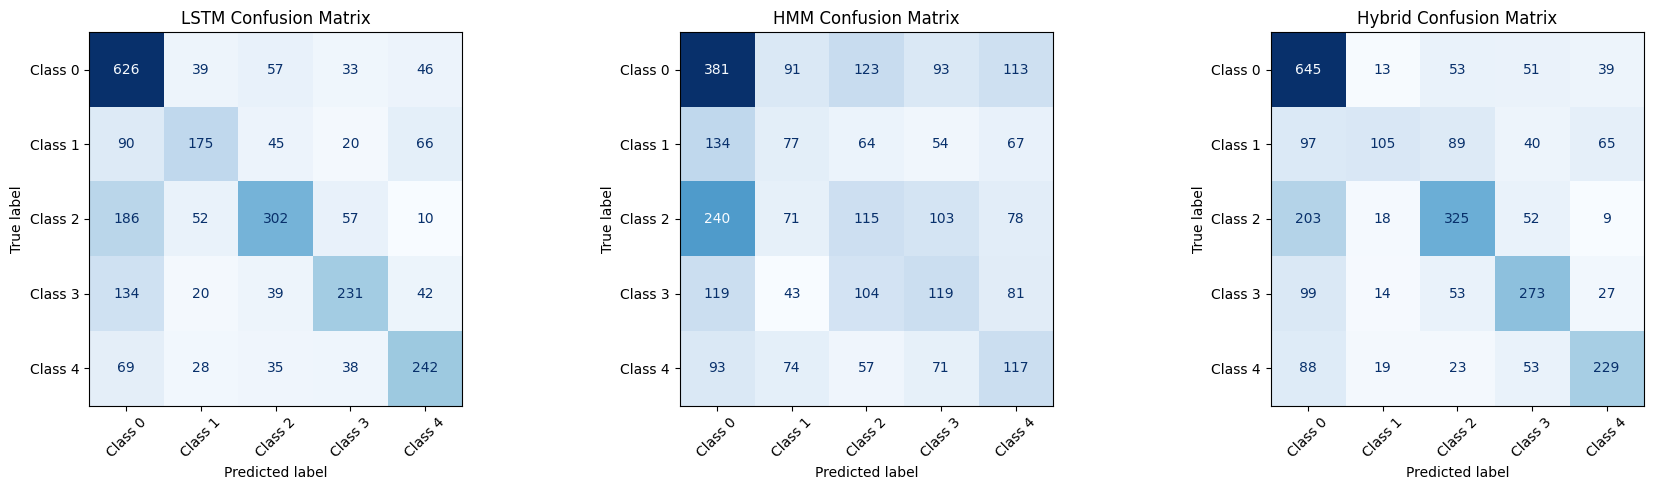

In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from hmmlearn.hmm import GaussianHMM
from scipy.special import softmax

# Paths
model_dir = "/content/drive/MyDrive/EmotionModels"
hybrid_path = f"{model_dir}/best_hybrid_model.keras"
lstm_path = f"{model_dir}/best_lstm_model.keras"
hmm_path = f"{model_dir}/hmms.pkl"

# Load data
X_train = np.load('/content/drive/MyDrive/EmotionFeaturesProcessed/X_train_padded.npy')
X_val = np.load('/content/drive/MyDrive/EmotionFeaturesProcessed/X_val_padded.npy')
y_train = np.load('/content/drive/MyDrive/EmotionFeaturesProcessed/y_train_onehot.npy')
y_val = np.load('/content/drive/MyDrive/EmotionFeaturesProcessed/y_val_onehot.npy')
y_true = np.argmax(y_val, axis=1)

# Utility functions
def unpad_sequence(seq):
    return seq[~np.all(seq == 0, axis=1)]

def normalize_sequence(seq):
    mean = np.mean(seq, axis=0)
    std = np.std(seq, axis=0) + 1e-6
    return (seq - mean) / std

def predict_hmm(X, hmms):
    preds = []
    for seq in X:
        unpadded = unpad_sequence(seq)
        norm = normalize_sequence(unpadded)
        scores = []
        for hmm in hmms:
            if hmm is None:
                scores.append(-1e9)
            else:
                try:
                    scores.append(hmm.score(norm))
                except:
                    scores.append(-1e9)
        scores = softmax(scores)
        preds.append(np.argmax(scores))
    return np.array(preds)

def append_hmm_scores(X, hmms):
    augmented = []
    for seq in X:
        unpadded = unpad_sequence(seq)
        norm = normalize_sequence(unpadded)
        scores = []
        for hmm in hmms:
            if hmm is None:
                scores.append(-1e9)
            else:
                try:
                    scores.append(hmm.score(norm))
                except:
                    scores.append(-1e9)
        scores = softmax(scores)
        scores_tiled = np.tile(scores, (seq.shape[0], 1))
        augmented.append(np.concatenate([seq, scores_tiled], axis=-1))
    return np.array(augmented)

# Model architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Masking, Bidirectional, LSTM, LayerNormalization, GlobalAveragePooling1D, Dense, Dropout

def build_improved_lstm(input_shape, num_classes):
    return Sequential([
        Input(shape=input_shape),
        Masking(mask_value=0.),
        Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)),
        LayerNormalization(),
        GlobalAveragePooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])

# Load HMMs
with open(hmm_path, "rb") as f:
    hmms = pickle.load(f)

# Prepare hybrid input
X_train_hybrid = append_hmm_scores(X_train, hmms)
X_val_hybrid = append_hmm_scores(X_val, hmms)

# Resume training hybrid model
hybrid_model = load_model(hybrid_path)

# Optional: Adjust based on how many epochs already completed
initial_epoch = 25  # Change this if needed
total_epochs = 40

checkpoint = ModelCheckpoint(hybrid_path, monitor='val_accuracy', save_best_only=True)
early_stop = EarlyStopping(patience=6, restore_best_weights=True)

hybrid_model.fit(
    X_train_hybrid, y_train,
    validation_data=(X_val_hybrid, y_val),
    epochs=total_epochs,
    initial_epoch=initial_epoch,
    batch_size=16,
    callbacks=[checkpoint, early_stop]
)

# Evaluate LSTM
lstm_model = load_model(lstm_path)
y_lstm_probs = lstm_model.predict(X_val)
y_lstm_pred = np.argmax(y_lstm_probs, axis=1)

# Evaluate HMM
y_hmm_pred = predict_hmm(X_val, hmms)

# Evaluate Hybrid
y_hybrid_probs = hybrid_model.predict(X_val_hybrid)
y_hybrid_pred = np.argmax(y_hybrid_probs, axis=1)

# Print Reports
print("\n=== LSTM Evaluation ===")
print(classification_report(y_true, y_lstm_pred))
print("LSTM Accuracy:", accuracy_score(y_true, y_lstm_pred))

print("\n=== HMM Evaluation ===")
print(classification_report(y_true, y_hmm_pred))
print("HMM Accuracy:", accuracy_score(y_true, y_hmm_pred))

print("\n=== Hybrid Evaluation ===")
print(classification_report(y_true, y_hybrid_pred))
print("Hybrid Accuracy:", accuracy_score(y_true, y_hybrid_pred))

# Plot Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

cm_lstm = confusion_matrix(y_true, y_lstm_pred)
cm_hmm = confusion_matrix(y_true, y_hmm_pred)
cm_hybrid = confusion_matrix(y_true, y_hybrid_pred)
labels = [f"Class {i}" for i in range(y_val.shape[1])]

for ax, cm, title in zip(axes, [cm_lstm, cm_hmm, cm_hybrid], ['LSTM', 'HMM', 'Hybrid']):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax, xticks_rotation=45, cmap='Blues', colorbar=False)
    ax.set_title(f"{title} Confusion Matrix")

plt.tight_layout()
plt.show()

RESULTS

84/84 ━━━━━━━━━━━━━━━━━━━━ 19s 208ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 225ms/step


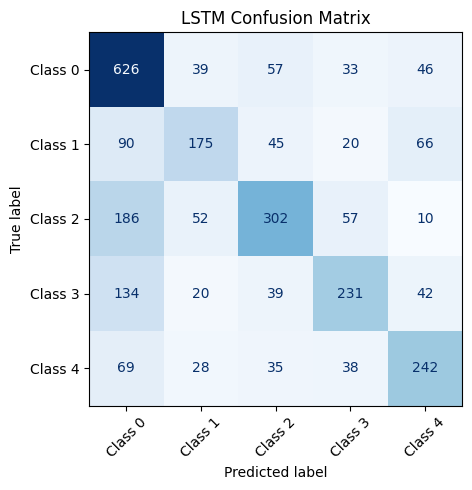

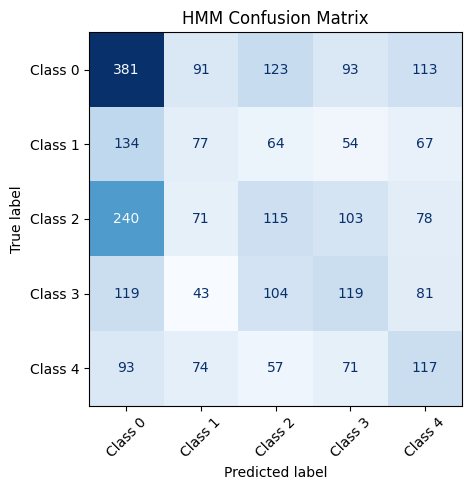

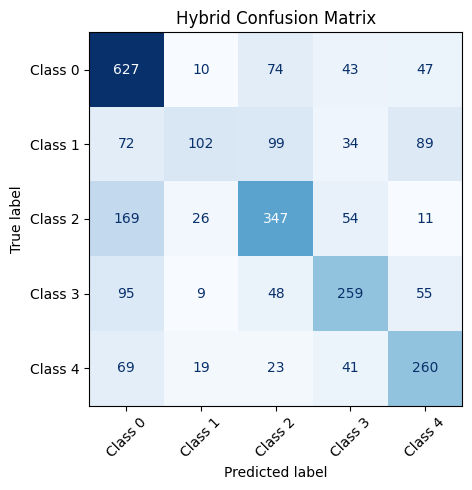

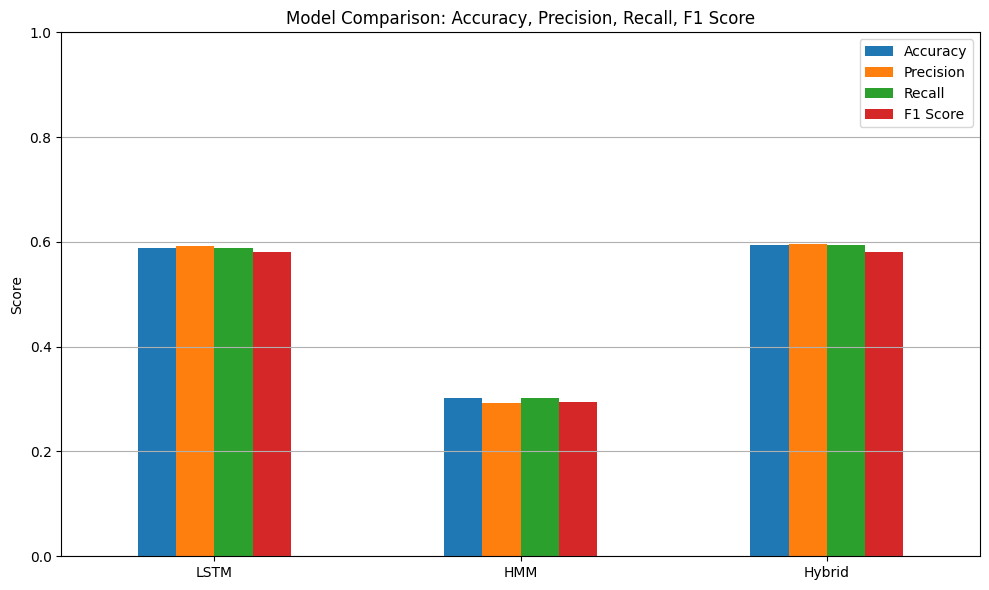

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix,
    ConfusionMatrixDisplay, roc_auc_score, mean_squared_error, r2_score,
    precision_score, recall_score, f1_score
)
import tensorflow as tf
from tensorflow.keras.models import load_model

# === Load Saved Models and Data ===
model_dir = "/content/drive/MyDrive/EmotionModels"
lstm_model = load_model(f"{model_dir}/best_lstm_model.keras")
hybrid_model = load_model(f"{model_dir}/best_hybrid_model.keras")
with open(f"{model_dir}/hmms.pkl", "rb") as f:
    hmms = pickle.load(f)

X_val = np.load('/content/drive/MyDrive/EmotionFeaturesProcessed/X_val_padded.npy')
y_val = np.load('/content/drive/MyDrive/EmotionFeaturesProcessed/y_val_onehot.npy')
y_true = np.argmax(y_val, axis=1)
class_labels = [f"Class {i}" for i in range(y_val.shape[1])]

# === Utility Functions ===
def unpad_sequence(seq):
    return seq[~np.all(seq == 0, axis=1)]

def normalize_sequence(seq):
    mean = np.mean(seq, axis=0)
    std = np.std(seq, axis=0) + 1e-6
    return (seq - mean) / std

def predict_hmm(X, hmms):
    preds = []
    for seq in X:
        unpadded = unpad_sequence(seq)
        norm = normalize_sequence(unpadded)
        scores = []
        for hmm in hmms:
            if hmm is None:
                scores.append(-1e9)
            else:
                try:
                    scores.append(hmm.score(norm))
                except:
                    scores.append(-1e9)
        scores = tf.nn.softmax(scores).numpy()
        preds.append(np.argmax(scores))
    return np.array(preds)

def append_hmm_scores(X, hmms):
    augmented = []
    for seq in X:
        unpadded = unpad_sequence(seq)
        norm = normalize_sequence(unpadded)
        scores = []
        for hmm in hmms:
            if hmm is None:
                scores.append(-1e9)
            else:
                try:
                    scores.append(hmm.score(norm))
                except:
                    scores.append(-1e9)
        scores = tf.nn.softmax(scores).numpy()
        scores_tiled = np.tile(scores, (seq.shape[0], 1))
        augmented.append(np.concatenate([seq, scores_tiled], axis=-1))
    return np.array(augmented)

# === Predictions ===
y_lstm_probs = lstm_model.predict(X_val)
y_lstm_pred = np.argmax(y_lstm_probs, axis=1)

X_val_hybrid = append_hmm_scores(X_val, hmms)
y_hybrid_probs = hybrid_model.predict(X_val_hybrid)
y_hybrid_pred = np.argmax(y_hybrid_probs, axis=1)

y_hmm_pred = predict_hmm(X_val, hmms)

# === Confusion Matrices ===
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax, xticks_rotation=45, cmap='Blues', colorbar=False)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

plot_conf_matrix(y_true, y_lstm_pred, "LSTM Confusion Matrix")
plot_conf_matrix(y_true, y_hmm_pred, "HMM Confusion Matrix")
plot_conf_matrix(y_true, y_hybrid_pred, "Hybrid Confusion Matrix")

# === Metric Evaluation ===
def compute_metrics(y_true, y_probs, y_pred):
    results = {}
    results['Accuracy'] = accuracy_score(y_true, y_pred)
    results['Precision'] = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    results['Recall'] = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    results['F1 Score'] = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    results['RMSE'] = np.sqrt(mean_squared_error(y_true, y_pred))
    results['MSE'] = mean_squared_error(y_true, y_pred)
    results['R2 Score'] = r2_score(y_true, y_pred)
    try:
        results['ROC-AUC'] = roc_auc_score(y_true, y_probs, multi_class='ovr', average='macro')
    except:
        results['ROC-AUC'] = None
    try:
        results['Cross-Entropy'] = np.mean(tf.keras.losses.categorical_crossentropy(
            tf.one_hot(y_true, depth=y_probs.shape[1]), y_probs
        ).numpy())
    except:
        results['Cross-Entropy'] = None

    report = classification_report(y_true, y_pred, output_dict=True)
    results['Macro Avg F1'] = report['macro avg']['f1-score']
    results['Weighted Avg F1'] = report['weighted avg']['f1-score']
    return results

metrics_lstm = compute_metrics(y_true, y_lstm_probs, y_lstm_pred)
metrics_hmm = compute_metrics(y_true, np.zeros_like(y_val), y_hmm_pred)
metrics_hybrid = compute_metrics(y_true, y_hybrid_probs, y_hybrid_pred)

# === Create and Save CSV ===
df_metrics = pd.DataFrame([metrics_lstm, metrics_hmm, metrics_hybrid], index=['LSTM', 'HMM', 'Hybrid'])
csv_path = "/content/drive/MyDrive/EmotionModels/model_metrics_summary.csv"
df_metrics.to_csv(csv_path)
df_metrics

# === Bar Chart: Accuracy, Precision, Recall, F1 ===
df_plot = df_metrics[['Accuracy', 'Precision', 'Recall', 'F1 Score']]
df_plot.plot(kind='bar', figsize=(10, 6))
plt.title("Model Comparison: Accuracy, Precision, Recall, F1 Score")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

# Assumes these are already defined from your earlier cells:
# y_true = np.argmax(y_val, axis=1)
# y_hybrid_pred = np.argmax(y_hybrid_probs, axis=1)

# Get classification report as a dictionary
hybrid_report = classification_report(y_true, y_hybrid_pred, output_dict=True, zero_division=0)

# Convert to DataFrame
class_metrics_df = pd.DataFrame(hybrid_report).transpose()

# Filter only emotion classes (exclude avg totals)
emotion_class_metrics = class_metrics_df.iloc[:y_val.shape[1]][['precision', 'recall', 'f1-score', 'support']]

# Optionally rename the index if you have actual class names
emotion_labels = ['Angry', 'Fear', 'Happy', 'Neutral', 'Sad'] # replace or reorder as needed
emotion_class_metrics.index = emotion_labels[:emotion_class_metrics.shape[0]]

# Show the result
display(emotion_class_metrics)

# Save to CSV
emotion_class_metrics.to_csv('/content/drive/MyDrive/EmotionModels/hybrid_class_metrics.csv')

,precision,recall,f1-score,support
Angry,0.607558,0.782772,0.684124,801.0
Fear,0.614458,0.257576,0.362989,396.0
Happy,0.587140,0.571664,0.579299,607.0
Neutral,0.600928,0.555794,0.577480,466.0
Sad,0.562771,0.631068,0.594966,412.0


MORE RESULTS, METRICS

84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 218ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 19s 215ms/step
=== Evaluation Metrics ===


,LSTM,HMM,Hybrid
Accuracy,0.5876,0.3016,0.5947
MAE,0.8579,1.4139,0.8378
MSE,2.2010,3.5690,2.1458
RMSE,1.4836,1.8892,1.4649
R2,-0.0680,-0.7318,-0.0412
ROC-AUC,0.8635,NaN,0.8656
Cross Entropy,1.0118,NaN,0.9997


<Figure size 1200x600 with 0 Axes>

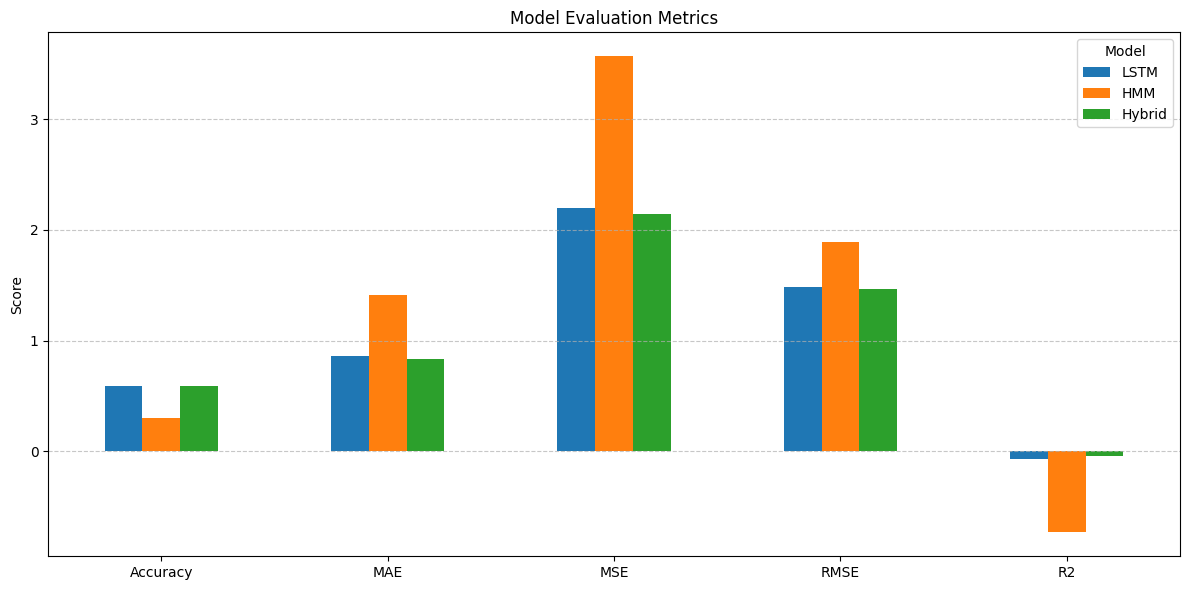

In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import (accuracy_score, classification_report, roc_auc_score, mean_absolute_error,
                             mean_squared_error, r2_score, log_loss)
from tensorflow.keras.models import load_model
from sklearn.preprocessing import label_binarize
from scipy.special import softmax

# Load paths
model_dir = "/content/drive/MyDrive/EmotionModels"
lstm_path = f"{model_dir}/best_lstm_model.keras"
hybrid_path = f"{model_dir}/best_hybrid_model.keras"
hmm_path = f"{model_dir}/hmms.pkl"

# Load data
X_train = np.load('/content/drive/MyDrive/EmotionFeaturesProcessed/X_train_padded.npy')
X_val = np.load('/content/drive/MyDrive/EmotionFeaturesProcessed/X_val_padded.npy')
y_train = np.load('/content/drive/MyDrive/EmotionFeaturesProcessed/y_train_onehot.npy')
y_val = np.load('/content/drive/MyDrive/EmotionFeaturesProcessed/y_val_onehot.npy')
y_true = np.argmax(y_val, axis=1)

# === HMM-related utils ===
def unpad_sequence(seq):
    return seq[~np.all(seq == 0, axis=1)]

def normalize_sequence(seq):
    mean = np.mean(seq, axis=0)
    std = np.std(seq, axis=0) + 1e-6
    return (seq - mean) / std

def predict_hmm(X, hmms):
    preds = []
    for seq in X:
        unpadded = unpad_sequence(seq)
        norm = normalize_sequence(unpadded)
        scores = []
        for hmm in hmms:
            if hmm is None:
                scores.append(-1e9)
            else:
                try:
                    scores.append(hmm.score(norm))
                except:
                    scores.append(-1e9)
        scores = softmax(scores)
        preds.append(np.argmax(scores))
    return np.array(preds)

def append_hmm_scores(X, hmms):
    augmented = []
    for seq in X:
        unpadded = unpad_sequence(seq)
        norm = normalize_sequence(unpadded)
        scores = []
        for hmm in hmms:
            if hmm is None:
                scores.append(-1e9)
            else:
                try:
                    scores.append(hmm.score(norm))
                except:
                    scores.append(-1e9)
        scores = softmax(scores)
        scores_tiled = np.tile(scores, (seq.shape[0], 1))
        augmented.append(np.concatenate([seq, scores_tiled], axis=-1))
    return np.array(augmented)

# === Load models and HMMs ===
lstm_model = load_model(lstm_path)
hybrid_model = load_model(hybrid_path)
with open(hmm_path, "rb") as f:
    hmms = pickle.load(f)

# Prepare hybrid input
X_val_hybrid = append_hmm_scores(X_val, hmms)

# === Predictions ===
y_lstm_probs = lstm_model.predict(X_val)
y_lstm_pred = np.argmax(y_lstm_probs, axis=1)

y_hybrid_probs = hybrid_model.predict(X_val_hybrid)
y_hybrid_pred = np.argmax(y_hybrid_probs, axis=1)

y_hmm_pred = predict_hmm(X_val, hmms)

# === Metric calculation ===
def calculate_metrics(y_true, y_pred, y_pred_probs=None):
    metrics = {}
    metrics["Accuracy"] = accuracy_score(y_true, y_pred)
    metrics["MAE"] = mean_absolute_error(y_true, y_pred)
    metrics["MSE"] = mean_squared_error(y_true, y_pred)
    metrics["RMSE"] = np.sqrt(metrics["MSE"])
    metrics["R2"] = r2_score(y_true, y_pred)
    if y_pred_probs is not None and y_pred_probs.ndim > 1:
        y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
        metrics["ROC-AUC"] = roc_auc_score(y_true_bin, y_pred_probs, average='macro', multi_class='ovr')
        metrics["Cross Entropy"] = log_loss(y_true, y_pred_probs)
    else:
        metrics["ROC-AUC"] = None
        metrics["Cross Entropy"] = None
    return metrics

# Compute metrics
lstm_metrics = calculate_metrics(y_true, y_lstm_pred, y_lstm_probs)
hmm_metrics = calculate_metrics(y_true, y_hmm_pred)
hybrid_metrics = calculate_metrics(y_true, y_hybrid_pred, y_hybrid_probs)

# === Convert to DataFrame for clean display ===
df_metrics = pd.DataFrame([lstm_metrics, hmm_metrics, hybrid_metrics],
                          index=["LSTM", "HMM", "Hybrid"]).T.round(4)

# Display table
print("=== Evaluation Metrics ===")
display(df_metrics)

# === Bar plot for selected metrics ===
plot_metrics = ["Accuracy", "MAE", "MSE", "RMSE", "R2", "ROC-AUC"]
df_metrics_plot = df_metrics.loc[plot_metrics].dropna()

plt.figure(figsize=(12, 6))
df_metrics_plot.plot(kind='bar', figsize=(12, 6))
plt.title("Model Evaluation Metrics")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

best_lstm_model = load_model(lstm_path)
best_hybrid_model = load_model(hybrid_path)
with open(os.path.join(model_dir, "hmms.pkl"), "rb") as f:
    hmms = pickle.load(f)

OPTIMIZING TO REDUCE TRAINING HOURS AND ERADICATE MARGINAL PERFORMANCE IN THE LSTM and Hybrid Model

In [ ]:
import numpy as np
import tensorflow as tf
import pickle
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Masking, Bidirectional, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error as MSE
from hmmlearn.hmm import GaussianHMM
from scipy.special import softmax
import warnings

model_dir = "/content/drive/MyDrive/EmotionModels"
os.makedirs(model_dir, exist_ok=True)

lstm_path = os.path.join(model_dir, "best_lstm_model2.keras")
hybrid_path = os.path.join(model_dir, "best_hybrid_model2.keras")

warnings.filterwarnings("ignore", category=RuntimeWarning)

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

# Load data
X_train = np.load('/content/drive/MyDrive/EmotionFeaturesProcessed/X_train_padded.npy')
X_val = np.load('/content/drive/MyDrive/EmotionFeaturesProcessed/X_val_padded.npy')
y_train = np.load('/content/drive/MyDrive/EmotionFeaturesProcessed/y_train_onehot.npy')
y_val = np.load('/content/drive/MyDrive/EmotionFeaturesProcessed/y_val_onehot.npy')

# Utils
def unpad_sequence(seq):
    return seq[~np.all(seq == 0, axis=1)]

def normalize_sequence(seq):
    mean = np.mean(seq, axis=0)
    std = np.std(seq, axis=0) + 1e-6
    return (seq - mean) / std

def predict_hmm(X, hmms):
    preds = []
    for seq in X:
        unpadded = unpad_sequence(seq)
        norm = normalize_sequence(unpadded)
        scores = []
        for hmm in hmms:
            if hmm is None:
                scores.append(-1e9)
            else:
                try:
                    scores.append(hmm.score(norm))
                except:
                    scores.append(-1e9)
        scores = softmax(scores)
        preds.append(np.argmax(scores))
    return np.array(preds)

def append_hmm_scores(X, hmms):
    augmented = []
    for seq in X:
        unpadded = unpad_sequence(seq)
        norm = normalize_sequence(unpadded)
        scores = []
        for hmm in hmms:
            if hmm is None:
                scores.append(-1e9)
            else:
                try:
                    scores.append(hmm.score(norm))
                except:
                    scores.append(-1e9)
        scores = softmax(scores)
        scores_tiled = np.tile(scores, (seq.shape[0], 1))
        augmented.append(np.concatenate([seq, scores_tiled], axis=-1))
    return np.array(augmented)

# Improved LSTM Model
def build_improved_lstm(input_shape, num_classes):
    return Sequential([
        Input(shape=input_shape),
        Masking(mask_value=0.),
        Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)),
        LayerNormalization(),
        GlobalAveragePooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])

# Mixed precision training setup
#from tensorflow.keras.mixed_precision import experimental as mixed_precision
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_global_policy(policy)

# Train LSTM
improved_model = build_improved_lstm(X_train.shape[1:], y_train.shape[1])
improved_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint_lstm = ModelCheckpoint(lstm_path, monitor='val_accuracy', save_best_only=True)
es = EarlyStopping(patience=6, restore_best_weights=True)

history_lstm = improved_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=16,
                                  callbacks=[es, checkpoint_lstm])

y_pred_probs = improved_model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)
print("=== LSTM Evaluation ===")
print(classification_report(y_true, y_pred))
print("LSTM Accuracy:", accuracy_score(y_true, y_pred))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_history(history, model_name):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history_lstm, "LSTM")

cm_lstm = confusion_matrix(y_true, y_pred)
#cm_hmm = confusion_matrix(y_true, y_hmm_pred)
#cm_hybrid = confusion_matrix(y_true, y_hybrid_pred)
labels = [f"Class {i}" for i in range(y_val.shape[1])]

# Define a helper function for plotting each confusion matrix
def plot_confusion_matrix(cm, title):
    fig, ax = plt.subplots(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax, xticks_rotation=45, cmap='Blues', colorbar=False)
    ax.set_title(f"{title} Confusion Matrix")
    plt.tight_layout()
    plt.show()

# Plot each confusion matrix separately
plot_confusion_matrix(cm_lstm, "LSTM")
#plot_confusion_matrix(cm_hmm, "HMM")
#plot_confusion_matrix(cm_hybrid, "Hybrid")

# Train HMMs per emotion class
hmms = []
num_classes = y_train.shape[1]
for i in range(num_classes):
    indices = np.argmax(y_train, axis=1) == i
    sequences = X_train[indices]

    cleaned = []
    lengths = []
    for seq in sequences:
        unpadded = unpad_sequence(seq)
        if unpadded.shape[0] > 10:
            normalized = normalize_sequence(unpadded)
            cleaned.append(normalized)
            lengths.append(len(normalized))

    if len(cleaned) < 5:
        print(f"Skipping class {i}: only {len(cleaned)} usable sequences.")
        hmms.append(None)
        continue

    data = np.concatenate(cleaned, axis=0)
    try:
        hmm = GaussianHMM(n_components=8, covariance_type='diag', n_iter=200, random_state=42)
        hmm.fit(data, lengths)
        if np.isnan(hmm.startprob_).any() or not np.isclose(hmm.startprob_.sum(), 1.0):
            print(f"Invalid startprob_ for class {i}.")
            hmms.append(None)
        else:
            hmms.append(hmm)
    except Exception as e:
        print(f"Failed training HMM for class {i}: {e}")
        hmms.append(None)

hmm_preds = predict_hmm(X_val, hmms)
print("\n=== HMM Evaluation ===")
print(classification_report(y_true, hmm_preds))
print("HMM Accuracy:", accuracy_score(y_true, hmm_preds))

with open(os.path.join(model_dir, "hmms2.pkl"), "wb") as f:
    pickle.dump(hmms, f)

# Hybrid Model with LSTM + HMM scores
X_train_hybrid = append_hmm_scores(X_train, hmms)
X_val_hybrid = append_hmm_scores(X_val, hmms)

hybrid_model = build_improved_lstm(X_train_hybrid.shape[1:], y_train.shape[1])
hybrid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint_hybrid = ModelCheckpoint(hybrid_path, monitor='val_accuracy', save_best_only=True)
history_hybrid = hybrid_model.fit(X_train_hybrid, y_train, validation_data=(X_val_hybrid, y_val), epochs=40, batch_size=16,
                                  callbacks=[es, checkpoint_hybrid])

y_hybrid_probs = hybrid_model.predict(X_val_hybrid)
y_hybrid_pred = np.argmax(y_hybrid_probs, axis=1)

print("\n=== Hybrid Model Evaluation ===")
print(classification_report(y_true, y_hybrid_pred))
print("Hybrid Accuracy:", accuracy_score(y_true, y_hybrid_pred))

# Plot Training History for LSTM and Hybrid Models
def plot_history(history, model_name):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history_lstm, "LSTM")
plot_history(history_hybrid, "Hybrid")

# Evaluate metrics
def evaluate_metrics(y_true, y_pred):
    rmse = np.sqrt(MSE(y_true, y_pred))
    mse = MSE(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovr')
    cross_entropy = np.mean(tf.keras.losses.categorical_crossentropy(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return rmse, mse, roc_auc, cross_entropy, r2

lstm_rmse, lstm_mse, lstm_roc_auc, lstm_ce, lstm_r2 = evaluate_metrics(y_true, y_pred)
hmm_rmse, hmm_mse, hmm_roc_auc, hmm_ce, hmm_r2 = evaluate_metrics(y_true, hmm_preds)
hybrid_rmse, hybrid_mse, hybrid_roc_auc, hybrid_ce, hybrid_r2 = evaluate_metrics(y_true, y_hybrid_pred)

# Display metrics in a table
import pandas as pd

metrics_df = pd.DataFrame({
    'Model': ['LSTM', 'HMM', 'Hybrid'],
    'RMSE': [lstm_rmse, hmm_rmse, hybrid_rmse],
    'MSE': [lstm_mse, hmm_mse, hybrid_mse],
    'ROC-AUC': [lstm_roc_auc, hmm_roc_auc, hybrid_roc_auc],
    'Cross-Entropy': [lstm_ce, hmm_ce, hybrid_ce],
    'R²': [lstm_r2, hmm_r2, hybrid_r2]
})

print(metrics_df)

cm_lstm = confusion_matrix(y_true, y_pred)
cm_hmm = confusion_matrix(y_true, y_hmm_preds)
cm_hybrid = confusion_matrix(y_true, y_hybrid_pred)
labels = [f"Class {i}" for i in range(y_val.shape[1])]

# Define a helper function for plotting each confusion matrix
def plot_confusion_matrix(cm, title):
    fig, ax = plt.subplots(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax, xticks_rotation=45, cmap='Blues', colorbar=False)
    ax.set_title(f"{title} Confusion Matrix")
    plt.tight_layout()
    plt.show()

# Plot each confusion matrix separately
plot_confusion_matrix(cm_lstm, "LSTM")
plot_confusion_matrix(cm_hmm, "HMM")
plot_confusion_matrix(cm_hybrid, "Hybrid")

CODE TO CONTINUE RUNNING IN CASE IT DISCONNECTS

In [ ]:
import numpy as np
import tensorflow as tf
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Masking, Bidirectional, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score, mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error as MSE
from hmmlearn.hmm import GaussianHMM
from scipy.special import softmax
import warnings


# Paths
model_dir = "/content/drive/MyDrive/EmotionModels"
hybrid_path = f"{model_dir}/best_hybrid_model2.keras"
lstm_path = f"{model_dir}/best_lstm_model2.keras"
hmm_path = f"{model_dir}/hmms2.pkl"

# Load data
X_train = np.load('/content/drive/MyDrive/EmotionFeaturesProcessed/X_train_padded.npy')
X_val = np.load('/content/drive/MyDrive/EmotionFeaturesProcessed/X_val_padded.npy')
y_train = np.load('/content/drive/MyDrive/EmotionFeaturesProcessed/y_train_onehot.npy')
y_val = np.load('/content/drive/MyDrive/EmotionFeaturesProcessed/y_val_onehot.npy')
y_true = np.argmax(y_val, axis=1)

# Utility functions
def unpad_sequence(seq):
    return seq[~np.all(seq == 0, axis=1)]

def normalize_sequence(seq):
    mean = np.mean(seq, axis=0)
    std = np.std(seq, axis=0) + 1e-6
    return (seq - mean) / std

def predict_hmm(X, hmms):
    preds = []
    for seq in X:
        unpadded = unpad_sequence(seq)
        norm = normalize_sequence(unpadded)
        scores = []
        for hmm in hmms:
            if hmm is None:
                scores.append(-1e9)
            else:
                try:
                    scores.append(hmm.score(norm))
                except:
                    scores.append(-1e9)
        scores = softmax(scores)
        preds.append(np.argmax(scores))
    return np.array(preds)

def append_hmm_scores(X, hmms):
    augmented = []
    for seq in X:
        unpadded = unpad_sequence(seq)
        norm = normalize_sequence(unpadded)
        scores = []
        for hmm in hmms:
            if hmm is None:
                scores.append(-1e9)
            else:
                try:
                    scores.append(hmm.score(norm))
                except:
                    scores.append(-1e9)
        scores = softmax(scores)
        scores_tiled = np.tile(scores, (seq.shape[0], 1))
        augmented.append(np.concatenate([seq, scores_tiled], axis=-1))
    return np.array(augmented)

# Model architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Masking, Bidirectional, LSTM, LayerNormalization, GlobalAveragePooling1D, Dense, Dropout

def build_improved_lstm(input_shape, num_classes):
    return Sequential([
        Input(shape=input_shape),
        Masking(mask_value=0.),
        Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)),
        LayerNormalization(),
        GlobalAveragePooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])

# Load HMMs
with open(hmm_path, "rb") as f:
    hmms = pickle.load(f)

# Prepare hybrid input
X_train_hybrid = append_hmm_scores(X_train, hmms)
X_val_hybrid = append_hmm_scores(X_val, hmms)

# Resume training hybrid model OR wherever model it stops
hybrid_model = load_model(hybrid_path)

# Optional: Adjust based on how many epochs already completed
initial_epoch = 9  # Change this if needed
total_epochs = 40

checkpoint = ModelCheckpoint(hybrid_path, monitor='val_accuracy', save_best_only=True)
early_stop = EarlyStopping(patience=6, restore_best_weights=True)

hybrid_model.fit(
    X_train_hybrid, y_train,
    validation_data=(X_val_hybrid, y_val),
    epochs=total_epochs,
    initial_epoch=initial_epoch,
    batch_size=16,
    callbacks=[checkpoint, early_stop]
)

# Evaluate LSTM
lstm_model = load_model(lstm_path)
y_lstm_probs = lstm_model.predict(X_val)
y_lstm_pred = np.argmax(y_lstm_probs, axis=1)

# Evaluate HMM
y_hmm_pred = predict_hmm(X_val, hmms)

# Evaluate Hybrid
y_hybrid_probs = hybrid_model.predict(X_val_hybrid)
y_hybrid_pred = np.argmax(y_hybrid_probs, axis=1)

# Print Reports
print("\n=== LSTM Evaluation ===")
print(classification_report(y_true, y_lstm_pred))
print("LSTM Accuracy:", accuracy_score(y_true, y_lstm_pred))

print("\n=== HMM Evaluation ===")
print(classification_report(y_true, y_hmm_pred))
print("HMM Accuracy:", accuracy_score(y_true, y_hmm_pred))

print("\n=== Hybrid Evaluation ===")
print(classification_report(y_true, y_hybrid_pred))
print("Hybrid Accuracy:", accuracy_score(y_true, y_hybrid_pred))

# Plot Training History for LSTM and Hybrid Models
def plot_history(history, model_name):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

#plot_history(history_lstm, "LSTM")
#plot_history(history_hybrid, "Hybrid")

# Evaluate metrics
def evaluate_metrics(y_true, y_probs, y_preds):
    rmse = np.sqrt(MSE(y_true, y_preds))
    mse = MSE(y_true, y_preds)
    roc_auc = roc_auc_score(y_true, y_probs, average='macro', multi_class='ovr')
    cross_entropy = np.mean(tf.keras.losses.categorical_crossentropy(tf.one_hot(y_true, depth=y_probs.shape[1]), y_probs))
    r2 = r2_score(y_true, y_preds)
    return rmse, mse, roc_auc, cross_entropy, r2

lstm_rmse, lstm_mse, lstm_roc_auc, lstm_ce, lstm_r2 = evaluate_metrics(y_true, y_lstm_probs, y_lstm_pred)
hmm_rmse, hmm_mse, hmm_roc_auc, hmm_ce, hmm_r2 = evaluate_metrics(y_true, None, y_hmm_pred)
hybrid_rmse, hybrid_mse, hybrid_roc_auc, hybrid_ce, hybrid_r2 = evaluate_metrics(y_true, y_hybrid_probs, y_hybrid_pred)

# Display metrics in a table
import pandas as pd

metrics_df = pd.DataFrame({
    'Model': ['LSTM', 'HMM', 'Hybrid'],
    'RMSE': [lstm_rmse, hmm_rmse, hybrid_rmse],
    'MSE': [lstm_mse, hmm_mse, hybrid_mse],
    'ROC-AUC': [lstm_roc_auc, hmm_roc_auc, hybrid_roc_auc],
    'Cross-Entropy': [lstm_ce, hmm_ce, hybrid_ce],
    'R²': [lstm_r2, hmm_r2, hybrid_r2]
})

print(metrics_df)
metrics_df.to_csv('/content/drive/MyDrive/EmotionModels/evaluation_metrics.csv', index=False)

# Plot Confusion Matrices
# Prepare confusion matrices and labels
cm_lstm = confusion_matrix(y_true, y_lstm_pred)
cm_hmm = confusion_matrix(y_true, y_hmm_pred)
cm_hybrid = confusion_matrix(y_true, y_hybrid_pred)
labels = [f"Class {i}" for i in range(y_val.shape[1])]

# Define a helper function for plotting each confusion matrix
def plot_confusion_matrix(cm, title):
    fig, ax = plt.subplots(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax, xticks_rotation=45, cmap='Blues', colorbar=False)
    ax.set_title(f"{title} Confusion Matrix")
    plt.tight_layout()
    plt.show()

# Plot each confusion matrix separately
plot_confusion_matrix(cm_lstm, "LSTM")
plot_confusion_matrix(cm_hmm, "HMM")
plot_confusion_matrix(cm_hybrid, "Hybrid")

Epoch 10/40
671/671 ━━━━━━━━━━━━━━━━━━━━ 872s 1s/step - accuracy: 0.4460 - loss: 1.2915 - val_accuracy: 0.5302 - val_loss: 1.1611
Epoch 11/40
671/671 ━━━━━━━━━━━━━━━━━━━━ 794s 1s/step - accuracy: 0.4518 - loss: 1.2841 - val_accuracy: 0.5324 - val_loss: 1.1752
Epoch 12/40
671/671 ━━━━━━━━━━━━━━━━━━━━ 793s 1s/step - accuracy: 0.4645 - loss: 1.2706 - val_accuracy: 0.5440 - val_loss: 1.1384
Epoch 13/40
671/671 ━━━━━━━━━━━━━━━━━━━━ 791s 1s/step - accuracy: 0.4712 - loss: 1.2458 - val_accuracy: 0.5254 - val_loss: 1.1299
Epoch 14/40
671/671 ━━━━━━━━━━━━━━━━━━━━ 782s 1s/step - accuracy: 0.4660 - loss: 1.2540 - val_accuracy: 0.5503 - val_loss: 1.1149
Epoch 15/40
671/671 ━━━━━━━━━━━━━━━━━━━━ 811s 1s/step - accuracy: 0.4648 - loss: 1.2580 - val_accuracy: 0.5444 - val_loss: 1.1200
Epoch 16/40
671/671 ━━━━━━━━━━━━━━━━━━━━ 788s 1s/step - accuracy: 0.4780 - loss: 1.2375 - val_accuracy: 0.5533 - val_loss: 1.1271
Epoch 17/40
671/671 ━━━━━━━━━━━━━━━━━━━━ 908s 1s/step - accuracy: 0.4920 - loss: 1.2332 - 

NameError: name 'y_pred' is not defined

CHECK IF MY DATA IS SCALED

In [ ]:
import numpy as np

# IMPORTANT: Ensure all my X_train and X_val are already loaded in a previous cell.
# If i am running this in a fresh session, I might need to re-mount my Google Driveyoutube
# and load the data like in my main script's initial data loading block.

print("--- Checking Feature Scaling ---")

if 'X_train' not in locals() or 'X_val' not in locals():
    print("X_train or X_val not found. Please ensure your data loading cell has been run.")
    print("If not, you can run the full initial data loading block first, or replace this message with dummy data for testing.")
    # You might want to uncomment and run the data loading part from your main script here
    # to ensure X_train and X_val are available for checking.
    # For demonstration, creating small dummy arrays if not found:
    try:
        # Attempt to load from default paths if main script's initial loading failed
        X_train = np.load('/content/drive/MyDrive/EmotionFeaturesProcessed/X_train_padded.npy')
        X_val = np.load('/content/drive/MyDrive/EmotionFeaturesProcessed/X_val_padded.npy')
        print("Data loaded from default paths for check.")
    except FileNotFoundError:
        print("Creating small dummy data for scaling check (for demonstration only).")
        X_train = np.random.rand(100, 10, 5).astype(np.float32) * 1000 # Unscaled example
        X_val = np.random.rand(20, 10, 5).astype(np.float32) * 1000   # Unscaled example
        print("Dummy data created.")


print("\nStatistics for X_train (across all timesteps and samples):")
# Reshape X_train to 2D (samples * timesteps, features) for easier statistics calculation
X_train_flat = X_train.reshape(-1, X_train.shape[-1])

print(f"  Min value: {np.min(X_train_flat):.4f}")
print(f"  Max value: {np.max(X_train_flat):.4f}")
print(f"  Mean value: {np.mean(X_train_flat):.4f}")
print(f"  Standard Deviation: {np.std(X_train_flat):.4f}")

print("\nStatistics for X_val (across all timesteps and samples):")
X_val_flat = X_val.reshape(-1, X_val.shape[-1])
print(f"  Min value: {np.min(X_val_flat):.4f}")
print(f"  Max value: {np.max(X_val_flat):.4f}")
print(f"  Mean value: {np.mean(X_val_flat):.4f}")
print(f"  Standard Deviation: {np.std(X_val_flat):.4f}")

print("\n--- Interpretation ---")
print("If your data is scaled:")
print("  - For **MinMaxScaler**: Min should be close to 0, Max close to 1.")
print("  - For **StandardScaler**: Mean should be close to 0, Standard Deviation close to 1.")
print("If values are widely varying (e.g., min in negative thousands, max in positive thousands, or large std dev), your data likely needs scaling.")

--- Checking Feature Scaling ---

Statistics for X_train (across all timesteps and samples):
  Min value: -14549151.0000
  Max value: 74282792.0000
  Mean value: 46.5173
  Standard Deviation: 19560.7031

Statistics for X_val (across all timesteps and samples):
  Min value: -9506594.0000
  Max value: 46695428.0000
  Mean value: 50.3507
  Standard Deviation: 21524.2539

--- Interpretation ---
If your data is scaled:
  - For **MinMaxScaler**: Min should be close to 0, Max close to 1.
  - For **StandardScaler**: Mean should be close to 0, Standard Deviation close to 1.
If values are widely varying (e.g., min in negative thousands, max in positive thousands, or large std dev), your data likely needs scaling.


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns # For visualizing distributions

# IMPORTANT: Ensure X_train and X_val are already loaded in a previous cell.
# If you are running this in a fresh session, you might need to re-mount your Google Drive
# and load the data like in your main script's initial data loading block.

print("--- Performing Feature Scaling ---")

if 'X_train' not in locals() or 'X_val' not in locals():
    print("X_train or X_val not found. Please ensure your data loading cell has been run.")
    print("If not, you can run the full initial data loading block first, or replace this message with dummy data for testing.")
    # Fallback to dummy data for demonstration if X_train is truly not defined
    try:
        # Attempt to load from default paths if main script's initial loading failed
        X_train = np.load('/content/drive/MyDrive/EmotionFeaturesProcessed/X_train_padded.npy')
        X_val = np.load('/content/drive/MyDrive/EmotionFeaturesProcessed/X_val_padded.npy')
        print("Data loaded from default paths for scaling.")
    except FileNotFoundError:
        print("Creating small dummy data for scaling (for demonstration only).")
        X_train = np.random.rand(100, 10, 5).astype(np.float32) * 1000 # Unscaled example
        X_val = np.random.rand(20, 10, 5).astype(np.float32) * 1000   # Unscaled example
        print("Dummy data created.")


original_X_train_shape = X_train.shape
original_X_val_shape = X_val.shape
num_features = X_train.shape[-1]

# Reshape 3D data to 2D for the scaler: (num_samples * timesteps, num_features)
# This treats all individual feature observations as independent samples for scaling purposes.
X_train_reshaped = X_train.reshape(-1, num_features)
X_val_reshaped = X_val.reshape(-1, num_features)

print(f"Original X_train shape: {original_X_train_shape}")
print(f"Reshaped X_train for scaler: {X_train_reshaped.shape}")

# --- Choose your scaler ---
# Option 1: MinMaxScaler (scales features to a given range, typically [0, 1])
scaler = MinMaxScaler()
print("\nUsing MinMaxScaler...")

# Option 2: StandardScaler (scales features to have mean=0 and std=1)
# scaler = StandardScaler()
# print("\nUsing StandardScaler...")

# Fit the scaler ONLY on the training data
scaler.fit(X_train_reshaped)

# Transform both training and validation data using the fitted scaler
X_train_scaled = scaler.transform(X_train_reshaped)
X_val_scaled = scaler.transform(X_val_reshaped)

# Reshape back to original 3D shape (samples, timesteps, features)
X_train = X_train_scaled.reshape(original_X_train_shape)
X_val = X_val_scaled.reshape(original_X_val_shape)

print("Data scaled and reshaped back to original dimensions.")
print(f"New X_train shape: {X_train.shape}")
print(f"New X_val shape: {X_val.shape}")

print("\n--- Verifying Scaling (after transformation) ---")
print("Statistics for X_train (scaled):")
X_train_flat_scaled = X_train.reshape(-1, num_features)
print(f"  Min value: {np.min(X_train_flat_scaled):.4f}")
print(f"  Max value: {np.max(X_train_flat_scaled):.4f}")
print(f"  Mean value: {np.mean(X_train_flat_scaled):.4f}")
print(f"  Standard Deviation: {np.std(X_train_flat_scaled):.4f}")

# Optional: Visualize distributions of a few features before and after scaling
# This part is for visual confirmation and requires a bit more setup if not using dummy data
if 'original_X_train' in locals(): # Only run if dummy data was generated in this cell
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(original_X_train.reshape(-1, num_features)[:, 0], kde=True, bins=50)
    plt.title('Feature 0 Distribution (Before Scaling)')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    sns.histplot(X_train_scaled[:, 0], kde=True, bins=50)
    plt.title('Feature 0 Distribution (After Scaling)')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

print("\nScaling complete. The `X_train` and `X_val` variables are now updated with scaled data.")
print("You can now proceed to run the model training cells.")

--- Performing Feature Scaling ---
Original X_train shape: (10724, 269, 26)
Reshaped X_train for scaler: (2884756, 26)

Using MinMaxScaler...
Data scaled and reshaped back to original dimensions.
New X_train shape: (10724, 269, 26)
New X_val shape: (2682, 269, 26)

--- Verifying Scaling (after transformation) ---
Statistics for X_train (scaled):
  Min value: 0.0000
  Max value: 1.0000
  Mean value: 0.4948
  Standard Deviation: 0.3132

Scaling complete. The `X_train` and `X_val` variables are now updated with scaled data.
You can now proceed to run the model training cells.


In [ ]:
import numpy as np

# --- Configuration ---
# IMPORTANT: Ensure y_train is loaded in a previous cell (e.g., your initial data loading cell).
# If you are running this in a fresh session or your main data loading failed,
# you might need to re-mount Google Drive and load y_train here.

# Define your 5 emotion labels - ENSURE THIS MATCHES YOUR MAIN SCRIPT'S ORDER!
# Example:
EMOTION_LABELS = ['angry', 'fear', 'happy', 'neutral', 'sad']
NUM_EMOTIONS = len(EMOTION_LABELS) # This should be 5 for your case

print("--- Manually Inspecting y_train Labels ---")

if 'y_train' not in locals():
    print("Warning: `y_train` not found in current environment. Attempting to load from default path.")
    # Assuming the default path from your main script setup
    try:
        y_train = np.load('/content/drive/MyDrive/EmotionFeaturesProcessed/y_train_onehot.npy')
        print(f"Loaded y_train from 'y_train.npy' (shape: {y_train.shape})")
    except FileNotFoundError:
        print("Error: 'y_train.npy' not found. Please ensure your data loading cell has been run or update the path.")
        print("Creating dummy y_train for demonstration purposes.")
        num_samples_train = 10724
        y_train_idx = np.random.randint(0, NUM_EMOTIONS, num_samples_train)
        y_train = np.eye(NUM_EMOTIONS)[y_train_idx].astype(np.float32)
        print(f"Dummy y_train created (shape: {y_train.shape})")


num_samples = y_train.shape[0]
samples_to_check = 10 # Number of random samples to inspect

print(f"\nInspecting {min(samples_to_check, num_samples)} random samples from y_train:")

# Get random indices to inspect
random_indices = np.random.choice(num_samples, min(samples_to_check, num_samples), replace=False)

for i, sample_idx in enumerate(random_indices):
    # Get the one-hot encoded vector for the current sample
    one_hot_vector = y_train[sample_idx]

    # Find the index of the '1' in the one-hot vector, which is the class label
    label_index = np.argmax(one_hot_vector)

    # Get the corresponding emotion label from your EMOTION_LABELS list
    # Add a check to prevent IndexError if label_index is out of bounds
    if label_index < NUM_EMOTIONS:
        emotion_name = EMOTION_LABELS[label_index]
    else:
        emotion_name = "ERROR: Index out of bounds for EMOTION_LABELS"


    print(f"Sample {i+1} (original y_train index: {sample_idx}):")
    print(f"  One-hot vector: {one_hot_vector}")
    print(f"  Deduced numerical label (index of '1'): {label_index}")
    print(f"  Corresponding emotion from EMOTION_LABELS: {emotion_name}")
    print("-" * 30)

print("\n--- Manual Verification Guidance ---")
print("Look at the 'Corresponding emotion from EMOTION_LABELS' for each sample.")
print("You should manually verify that the emotion displayed for each `Sample` is what you expect based on your knowledge of the original audio data.")
print("For example, if you know `y_train` index 0 should represent 'Angry', then you should ensure the output `Deduced numerical label: 0` maps to `Corresponding emotion: Angry`.")
print("If the emotions don't match your expectations, you need to adjust the order of `EMOTION_LABELS` in your main script to correctly align with your one-hot encoding.")

# --- Configuration ---
# IMPORTANT: Ensure y_train is loaded in a previous cell (e.g., your initial data loading cell).
# If you are running this in a fresh session or your main data loading failed,
# you might need to re-mount Google Drive and load y_train here.

# Define your 5 emotion labels - ENSURE THIS MATCHES YOUR MAIN SCRIPT'S ORDER!
# Example:
EMOTION_LABELS = ['angry', 'fear', 'happy', 'neutral', 'sad']
NUM_EMOTIONS = len(EMOTION_LABELS) # This should be 5 for your case

print("--- Manually Inspecting y_train Labels ---")

if 'y_train' not in locals():
    print("Warning: `y_train` not found in current environment. Attempting to load from default path.")
    # Assuming the default path from your main script setup
    try:
        y_train = np.load('y_train.npy')
        print(f"Loaded y_train from 'y_train.npy' (shape: {y_train.shape})")
    except FileNotFoundError:
        print("Error: 'y_train.npy' not found. Please ensure your data loading cell has been run or update the path.")
        print("Creating dummy y_train for demonstration purposes.")
        num_samples_train = 10724
        y_train_idx = np.random.randint(0, NUM_EMOTIONS, num_samples_train)
        y_train = np.eye(NUM_EMOTIONS)[y_train_idx].astype(np.float32)
        print(f"Dummy y_train created (shape: {y_train.shape})")


num_samples = y_train.shape[0]
samples_to_check = 10 # Number of random samples to inspect

print(f"\nInspecting {min(samples_to_check, num_samples)} random samples from y_train:")

# Get random indices to inspect
random_indices = np.random.choice(num_samples, min(samples_to_check, num_samples), replace=False)

for i, sample_idx in enumerate(random_indices):
    # Get the one-hot encoded vector for the current sample
    one_hot_vector = y_train[sample_idx]

    # Find the index of the '1' in the one-hot vector, which is the class label
    label_index = np.argmax(one_hot_vector)

    # Get the corresponding emotion label from your EMOTION_LABELS list
    # Add a check to prevent IndexError if label_index is out of bounds
    if label_index < NUM_EMOTIONS:
        emotion_name = EMOTION_LABELS[label_index]
    else:
        emotion_name = "ERROR: Index out of bounds for EMOTION_LABELS"


    print(f"Sample {i+1} (original y_train index: {sample_idx}):")
    print(f"  One-hot vector: {one_hot_vector}")
    print(f"  Deduced numerical label (index of '1'): {label_index}")
    print(f"  Corresponding emotion from EMOTION_LABELS: {emotion_name}")
    print("-" * 30)

print("\n--- Manual Verification Guidance ---")
print("Look at the 'Corresponding emotion from EMOTION_LABELS' for each sample.")
print("You should manually verify that the emotion displayed for each `Sample` is what you expect based on your knowledge of the original audio data.")
print("For example, if you know `y_train` index 0 should represent 'Angry', then you should ensure the output `Deduced numerical label: 0` maps to `Corresponding emotion: Angry`.")
print("If the emotions don't match your expectations, you need to adjust the order of `EMOTION_LABELS` in your main script to correctly align with your one-hot encoding.")

--- Manually Inspecting y_train Labels ---

Inspecting 10 random samples from y_train:
Sample 1 (original y_train index: 7628):
  One-hot vector: [1. 0. 0. 0. 0.]
  Deduced numerical label (index of '1'): 0
  Corresponding emotion from EMOTION_LABELS: angry
------------------------------
Sample 2 (original y_train index: 107):
  One-hot vector: [0. 0. 0. 0. 1.]
  Deduced numerical label (index of '1'): 4
  Corresponding emotion from EMOTION_LABELS: sad
------------------------------
Sample 3 (original y_train index: 8789):
  One-hot vector: [0. 0. 1. 0. 0.]
  Deduced numerical label (index of '1'): 2
  Corresponding emotion from EMOTION_LABELS: happy
------------------------------
Sample 4 (original y_train index: 7091):
  One-hot vector: [0. 0. 1. 0. 0.]
  Deduced numerical label (index of '1'): 2
  Corresponding emotion from EMOTION_LABELS: happy
------------------------------
Sample 5 (original y_train index: 3404):
  One-hot vector: [0. 0. 0. 1. 0.]
  Deduced numerical label (index

tackling the HMM issue

In [ ]:
import numpy as np
# Define paths for the data files
X_train_path = '/content/drive/MyDrive/EmotionFeaturesProcessed/X_train_padded.npy'
X_val_path = '/content/drive/MyDrive/EmotionFeaturesProcessed/X_val_padded.npy'
y_train_path = '/content/drive/MyDrive/EmotionFeaturesProcessed/y_train_onehot.npy'
y_val_path = '/content/drive/MyDrive/EmotionFeaturesProcessed/y_val_onehot.npy'

# Load the data
X_train = np.load(X_train_path)
X_val = np.load(X_val_path)
y_train = np.load(y_train_path)
y_val = np.load(y_val_path)

for i in range(y_train.shape[1]):
    indices = np.argmax(y_train, axis=1) == i
    sequences = X_train[indices]
    print(f"Class {i}: {sequences.shape}")

Class 0: (3204, 269, 26)
Class 1: (1584, 269, 26)
Class 2: (2426, 269, 26)
Class 3: (1861, 269, 26)
Class 4: (1649, 269, 26)


COMPARING WITH A BASELINES MODEL

CNN-LSTM

Replaced my build_improved_lstm() and its training block with the following CNN+LSTM setup

This is it

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Masking, Bidirectional, LayerNormalization, GlobalAveragePooling1D, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, mean_squared_error, confusion_matrix, r2_score

from scipy.special import softmax
import warnings
import os

model_dir = "/content/drive/MyDrive/EmotionModels"
# os.makedirs(model_dir, exist_ok=True)

warnings.filterwarnings("ignore", category=RuntimeWarning)

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)

# Load data
X_train = np.load('/content/drive/MyDrive/EmotionFeaturesProcessed/X_train_padded.npy')
X_val = np.load('/content/drive/MyDrive/EmotionFeaturesProcessed/X_val_padded.npy')
y_train = np.load('/content/drive/MyDrive/EmotionFeaturesProcessed/y_train_onehot.npy')
y_val = np.load('/content/drive/MyDrive/EmotionFeaturesProcessed/y_val_onehot.npy')

import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, mean_squared_error, confusion_matrix, classification_report, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

# === CNN + LSTM Model ===
def build_cnn_lstm_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        #tf.keras.layers.Masking(mask_value=0.),
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)),
        tf.keras.layers.LayerNormalization(),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Paths
cnn_lstm_path = os.path.join(model_dir, "best_cnn_lstm_model.keras")

# Build & Compile
cnn_lstm_model = build_cnn_lstm_model(X_train.shape[1:], y_train.shape[1])
cnn_lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint_cnn_lstm = ModelCheckpoint(cnn_lstm_path, monitor='val_accuracy', save_best_only=True)
es_cnn_lstm = EarlyStopping(patience=6, restore_best_weights=True)

# Train
history_cnn_lstm = cnn_lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=16,
    callbacks=[checkpoint_cnn_lstm, es_cnn_lstm]
)

# Plot Accuracy vs Epoch & Loss vs Epoch
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_cnn_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn_lstm.history['loss'], label='Train Loss')
plt.plot(history_cnn_lstm.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate
y_cnn_lstm_probs = cnn_lstm_model.predict(X_val)
y_cnn_lstm_pred = np.argmax(y_cnn_lstm_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

# === Evaluation Metrics ===
# Compute ROC-AUC for multi-class
roc_auc = roc_auc_score(y_val, y_cnn_lstm_probs, multi_class='ovr')
print("ROC-AUC Score:", roc_auc)

# Compute RMSE and MSE
mse = mean_squared_error(y_true, y_cnn_lstm_pred)
rmse = np.sqrt(mse)
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

# Compute R2
r2 = r2_score(y_true, y_cnn_lstm_pred)
print(f"R^2 Score: {r2}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_cnn_lstm_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_cnn_lstm_pred))

# Optional: Save predictions if comparing later
np.save(os.path.join(model_dir, "y_cnn_lstm_probs.npy"), y_cnn_lstm_probs)
np.save(os.path.join(model_dir, "y_cnn_lstm_pred.npy"), y_cnn_lstm_pred)